# Libraries 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
# from statsFuncs import mean_confidence_interval
# from statsFuncs import compDistributions
import scipy
import random
import math 
from scipy import stats
mpl.rcParams['axes.linewidth'] = 2

import numpy as np
from scipy.integrate import cumtrapz
from scipy.stats import norm
from matplotlib import pyplot as plt
from statsFuncs import compDistributions



# Paths 

In [3]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
# datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'
datapath = figures_path + '/data/radiologists/Analysis9_29_2020/rbf_back/'

# Plot params 

In [4]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject params 

In [5]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

133 files, 15 folders
14 subjects


In [6]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

# Plot histograms 

Text(0.5, 1.0, 'Radiologists\n\n')

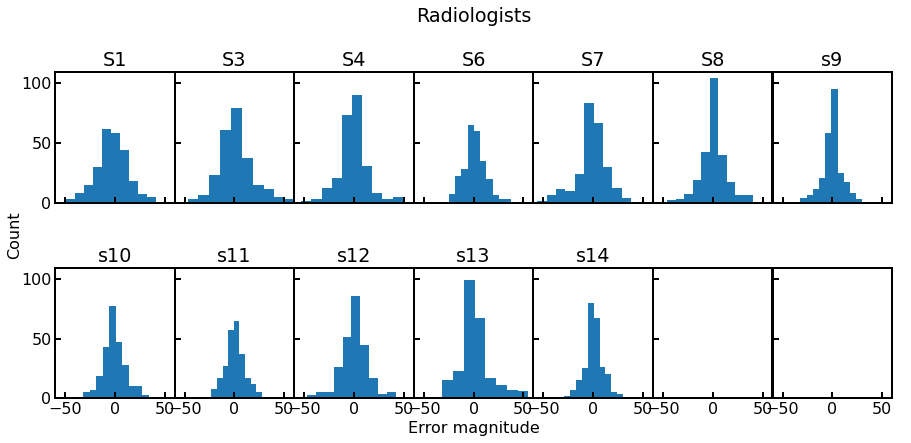

In [7]:
df_percentiles = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])
alldata = pd.DataFrame()

row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()
subject_names_wsuper = subject_names[:-1]
for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    df_percentiles.loc[row,'SUBJECT'] = subject
    alldata[subject] = subjectdata['responseError']

    axs[row].hist(subjectdata['responseError'])
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
    axs[row].set_title(subject)

    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n')

# CRD

## Define functions 

In [8]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

# def sigmoid(x,a):
#     return 1/(1+np.exp(-a*x)) + 0

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x-mean)**2/(2*stddev**2))

def gaussian_original(x, amplitude, mean, stddev):
    return amplitude * ((1/(stddev*np.sqrt(2*np.pi))) * np.exp((-1/2)*(((x-mean)**2)/(stddev**2))))

def cauchy(x, gamma, amplitude, mean):
    return (1/(np.pi*gamma*(1+((x-mean)/gamma)**2)))*amplitude

def vm(x, mean, kai, amplitude):
    x = (x/53)*np.pi
    return amplitude * (np.exp(kai * np.cos(x-mean)) / (i0(kai) * 2 * np.pi))
                  
def cdf(counts):
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    counts_filtered = counts.copy()
    
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    

        
    
    return cdf, cdf_filtered, counts_filtered
    
def cdf_gaussian_cauchy(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    
    if title=='SuperSubject':
        counts = counts/13
    
    cdf_og, cdf_filtered_og, counts_filtered_og = cdf(counts)
    
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
#     print(popt_gaussian)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    counts_vm = vm(bin_edges[1:,], *popt_vm)
    
    cdf_cauchy, cdf_filtered_cauchy, counts_cauchy_filtered = cdf(counts_cauchy)
    cdf_gaussian, cdf_filtered_gaussian, counts_gaussian_filtered = cdf(counts_gaussian)
    cdf_vm, cdf_filtered_vm, counts_vm_filtered = cdf(counts_vm)
    
    
    bestvals_og, temp_og = curve_fit(sigmoid,bin_edges[1:],cdf_og,p0=[3])
    bestvals_cauchy, temp_cauchy = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_cauchy,p0=[3])
    bestvals_gaussian, temp_gaussian = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_gaussian,p0=[3])
    bestvals_vm, temp_vm = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_vm,p0=[3])
    print(bestvals_vm)
    print(bin_edges[1:])
    print(cdf_filtered_vm)
    
    perc_25_og = inverse_sigmoid(0.25, bestvals_og)
    perc_75_og = inverse_sigmoid(0.75, bestvals_og)
        
    perc_25_cauchy = inverse_sigmoid(0.25, bestvals_cauchy)
    perc_75_cauchy = inverse_sigmoid(0.75, bestvals_cauchy)
    
    perc_25_gaussian = inverse_sigmoid(0.25, bestvals_gaussian)
    perc_75_gaussian = inverse_sigmoid(0.75, bestvals_gaussian)

    perc_25_vm = inverse_sigmoid(0.25, bestvals_vm)
    perc_75_vm = inverse_sigmoid(0.75, bestvals_vm)    
    
    plt.plot(bin_edges[1:], cdf_og, color='red', linewidth=1.5, label='original')
#     plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_og), color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_cauchy), color='blue', linewidth=2.5,label='cauchy')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_gaussian), color='green', linewidth=2.5,label='gaussian')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_vm), color='purple', linewidth=2.5,label='vm')
    
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75_og - perc_25_og)/2, (perc_75_gaussian - perc_25_gaussian)/2, (perc_75_cauchy - perc_25_cauchy)/2, (perc_75_vm - perc_25_vm)/2


## Calculate CRD w Gaussian, Cauchy and VM fit 

[0.23632259]
[-47.2 -45.4 -43.6 -41.8 -40.  -38.2 -36.4 -34.6 -32.8 -31.  -29.2 -27.4
 -25.6 -23.8 -22.  -20.2 -18.4 -16.6 -14.8 -13.  -11.2  -9.4  -7.6  -5.8
  -4.   -2.2  -0.4   1.4   3.2   5.    6.8   8.6  10.4  12.2  14.   15.8
  17.6  19.4  21.2  23.   24.8  26.6  28.4  30.2  32.   33.8  35.6  37.4
  39.2  41. ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02568167 0.05569333 0.09039088
 0.13001257 0.17463339 0.22412425 0.27812304 0.33602378 0.39698875
 0.45998552 0.52384655 0.5873454  0.64928042 0.70855526 0.76424624
 0.81564919 0.86230173 0.90398156 0.94068412 0.9725859  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


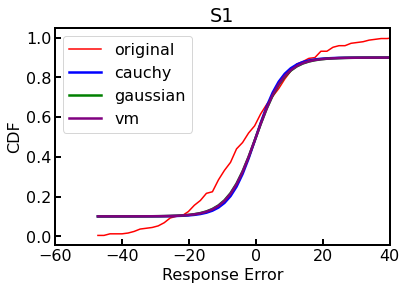

[0.29508412]
[-44.82098279 -42.64096273 -40.46094267 -38.28092262 -36.10090256
 -33.9208825  -31.74086244 -29.56084239 -27.38082233 -25.20080227
 -23.02078222 -20.84076216 -18.6607421  -16.48072205 -14.30070199
 -12.12068193  -9.94066188  -7.76064182  -5.58062176  -3.40060171
  -1.22058165   0.95943841   3.13945846   5.31947852   7.49949858
   9.67951864  11.85953869  14.03955875  16.21957881  18.39959886
  20.57961892  22.75963898  24.93965903  27.11967909  29.29969915
  31.4797192   33.65973926  35.83975932  38.01977937  40.19979943
  42.37981949  44.55983955  46.7398596   48.91987966  51.09989972
  53.27991977  55.45993983  57.63995989  59.81997994  62.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.0276182  0.06476687 0.11310722 0.1736954  0.2465643
 0.33040137 0.42245781 0.5187784  0.61474124 0.70578139 0.78809849
 0.85915501 0.91785523 0.9644118  1.         1.         1.
 1.         1.  

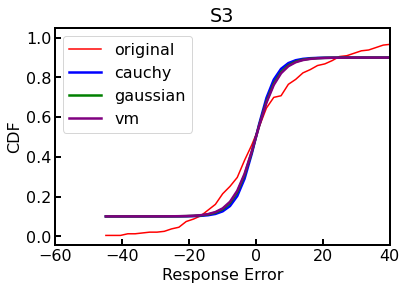

<ipython-input-8-db1c95758aa1>:2: RuntimeWarning: overflow encountered in exp
  return 0.8/(1+np.exp(-a*x)) + 0.1


[0.39751013]
[-5.09601309e+01 -4.89202618e+01 -4.68803928e+01 -4.48405237e+01
 -4.28006546e+01 -4.07607855e+01 -3.87209164e+01 -3.66810473e+01
 -3.46411783e+01 -3.26013092e+01 -3.05614401e+01 -2.85215710e+01
 -2.64817019e+01 -2.44418328e+01 -2.24019638e+01 -2.03620947e+01
 -1.83222256e+01 -1.62823565e+01 -1.42424874e+01 -1.22026183e+01
 -1.01627493e+01 -8.12288018e+00 -6.08301109e+00 -4.04314201e+00
 -2.00327293e+00  3.65961566e-02  2.07646524e+00  4.11633432e+00
  6.15620341e+00  8.19607249e+00  1.02359416e+01  1.22758107e+01
  1.43156797e+01  1.63555488e+01  1.83954179e+01  2.04352870e+01
  2.24751561e+01  2.45150252e+01  2.65548942e+01  2.85947633e+01
  3.06346324e+01  3.26745015e+01  3.47143706e+01  3.67542396e+01
  3.87941087e+01  4.08339778e+01  4.28738469e+01  4.49137160e+01
  4.69535851e+01  4.89934541e+01]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

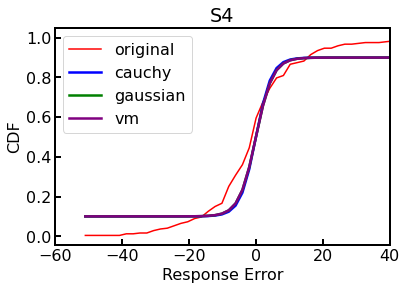

[0.36023513]
[-23.74 -22.48 -21.22 -19.96 -18.7  -17.44 -16.18 -14.92 -13.66 -12.4
 -11.14  -9.88  -8.62  -7.36  -6.1   -4.84  -3.58  -2.32  -1.06   0.2
   1.46   2.72   3.98   5.24   6.5    7.76   9.02  10.28  11.54  12.8
  14.06  15.32  16.58  17.84  19.1   20.36  21.62  22.88  24.14  25.4
  26.66  27.92  29.18  30.44  31.7   32.96  34.22  35.48  36.74  38.  ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0296053
 0.06445771 0.10480987 0.15072085 0.20201522 0.25825682 0.3187432
 0.38252448 0.44844736 0.5152212  0.58149973 0.64596913 0.70743241
 0.76488037 0.81754199 0.86490997 0.90674145 0.94303673 0.97400163
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


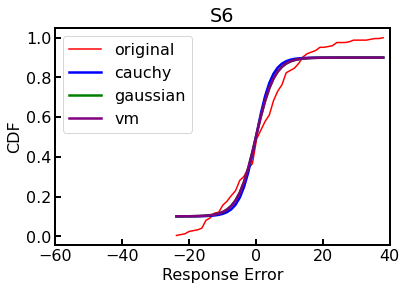

[0.37495073]
[-54.10541763 -52.22576337 -50.34610911 -48.46645485 -46.58680059
 -44.70714632 -42.82749206 -40.9478378  -39.06818354 -37.18852928
 -35.30887502 -33.42922076 -31.54956649 -29.66991223 -27.79025797
 -25.91060371 -24.03094945 -22.15129519 -20.27164092 -18.39198666
 -16.5123324  -14.63267814 -12.75302388 -10.87336962  -8.99371535
  -7.11406109  -5.23440683  -3.35475257  -1.47509831   0.40455595
   2.28421021   4.16386448   6.04351874   7.923173     9.80282726
  11.68248152  13.56213578  15.44179005  17.32144431  19.20109857
  21.08075283  22.96040709  24.84006135  26.71971562  28.59936988
  30.47902414  32.3586784   34.23833266  36.11798692  37.99764118]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.03681648
 0.08674813 0.15125797 0.230401   0.32236863 0.42340652 0.52822885
 0.63087569 0.7

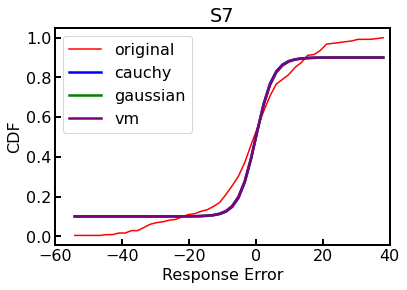

[0.43131054]
[-44.27414966 -42.55433759 -40.83452552 -39.11471345 -37.39490138
 -35.67508931 -33.95527724 -32.23546517 -30.5156531  -28.79584103
 -27.07602896 -25.35621689 -23.63640482 -21.91659275 -20.19678068
 -18.47696861 -16.75715654 -15.03734447 -13.3175324  -11.59772033
  -9.87790826  -8.15809619  -6.43828412  -4.71847205  -2.99865998
  -1.27884791   0.44096416   2.16077623   3.8805883    5.60040037
   7.32021244   9.04002451  10.75983658  12.47964865  14.19946072
  15.91927279  17.63908486  19.35889693  21.078709    22.79852107
  24.51833314  26.23814521  27.95795728  29.67776935  31.39758142
  33.11739349  34.83720556  36.55701763  38.2768297   39.99664177]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03464933 0.08381729 0.14966212
 0.23262738 0.33074876 0.43948324 0.55226634 0.66171969 0.76113595
 0.8457345  0.9

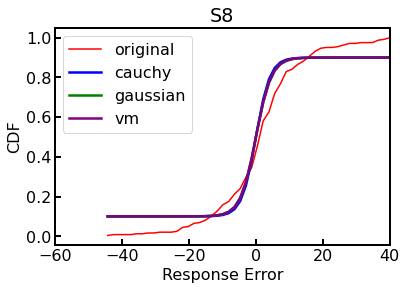

[0.48031473]
[-30.76007057 -29.52014115 -28.28021172 -27.04028229 -25.80035287
 -24.56042344 -23.32049401 -22.08056459 -20.84063516 -19.60070573
 -18.3607763  -17.12084688 -15.88091745 -14.64098802 -13.4010586
 -12.16112917 -10.92119974  -9.68127032  -8.44134089  -7.20141146
  -5.96148204  -4.72155261  -3.48162318  -2.24169376  -1.00176433
   0.2381651    1.47809452   2.71802395   3.95795338   5.19788281
   6.43781223   7.67774166   8.91767109  10.15760051  11.39752994
  12.63745937  13.87738879  15.11731822  16.35724765  17.59717707
  18.8371065   20.07703593  21.31696535  22.55689478  23.79682421
  25.03675363  26.27668306  27.51661249  28.75654192  29.99647134]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0284232  0.0655452  0.11241529 0.16955253 0.23673214 0.3128472
 0.39589459 0.48311117 0.57125159 0.65696116 0.73717095 0.80943538
 0.87214958 0.924

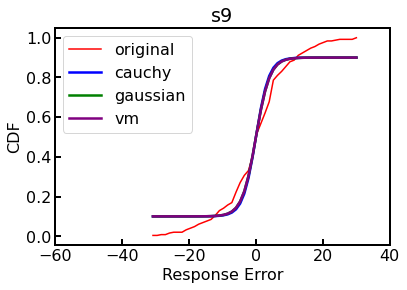

[0.3575488]
[-30.68098516 -29.36096505 -28.04094495 -26.72092484 -25.40090474
 -24.08088463 -22.76086453 -21.44084442 -20.12082431 -18.80080421
 -17.4807841  -16.160764   -14.84074389 -13.52072379 -12.20070368
 -10.88068358  -9.56066347  -8.24064337  -6.92062326  -5.60060316
  -4.28058305  -2.96056295  -1.64054284  -0.32052274   0.99949737
   2.31951747   3.63953758   4.95955768   6.27957779   7.5995979
   8.919618    10.23963811  11.55965821  12.87967832  14.19969842
  15.51971853  16.83973863  18.15975874  19.47977884  20.79979895
  22.11981905  23.43983916  24.75985926  26.07987937  27.39989947
  28.71991958  30.03993968  31.35995979  32.67997989  34.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02669768 0.05893737 0.09716924 0.14164517 0.1923544
 0.24897351 0.31084067 0.37696218 0.4460552  0.51662477 0.58706755
 0.65578961 0.7213229  0.78242559 0.83815407 0.88789998 0.93139128
 0.9686621

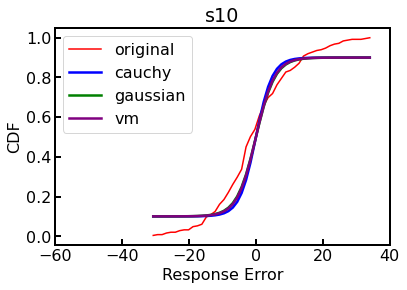

[0.4339516]
[-21.88025951 -20.76051901 -19.64077852 -18.52103802 -17.40129753
 -16.28155703 -15.16181654 -14.04207605 -12.92233555 -11.80259506
 -10.68285456  -9.56311407  -8.44337358  -7.32363308  -6.20389259
  -5.08415209  -3.9644116   -2.8446711   -1.72493061  -0.60519012
   0.51455038   1.63429087   2.75403137   3.87377186   4.99351236
   6.11325285   7.23299334   8.35273384   9.47247433  10.59221483
  11.71195532  12.83169581  13.95143631  15.0711768   16.1909173
  17.31065779  18.43039829  19.55013878  20.66987927  21.78961977
  22.90936026  24.02910076  25.14884125  26.26858175  27.38832224
  28.50806273  29.62780323  30.74754372  31.86728422  32.98702471]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02813139
 0.06209903 0.10230123 0.14890513 0.20178616 0.26048659 0.32420232
 0.39180427 0.46189583 0.53290216 0.60318161 0.67114568 0.73537215
 0.79469756 0.8482786  0.8956177  0.9365536  0.97122265 1.
 1.      

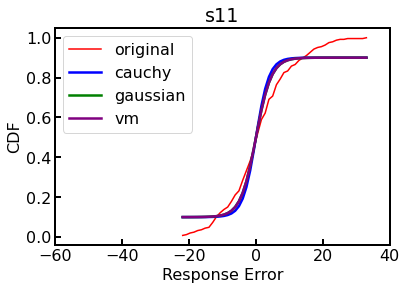

[0.30063035]
[-45.22003358 -43.44006716 -41.66010074 -39.88013432 -38.10016791
 -36.32020149 -34.54023507 -32.76026865 -30.98030223 -29.20033581
 -27.42036939 -25.64040297 -23.86043655 -22.08047014 -20.30050372
 -18.5205373  -16.74057088 -14.96060446 -13.18063804 -11.40067162
  -9.6207052   -7.84073879  -6.06077237  -4.28080595  -2.50083953
  -0.72087311   1.05909331   2.83905973   4.61902615   6.39899257
   8.17895898   9.9589254   11.73889182  13.51885824  15.29882466
  17.07879108  18.8587575   20.63872392  22.41869034  24.19865675
  25.97862317  27.75858959  29.53855601  31.31852243  33.09848885
  34.87845527  36.65842169  38.43838811  40.21835452  41.99832094]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02630997 0.05956043 0.10060939 0.14999678 0.2077859  0.27343572
 0.34573973 0.42285957 0.50246333 0.58195315 0.65874352 0.73053723
 0.79554648 0.8

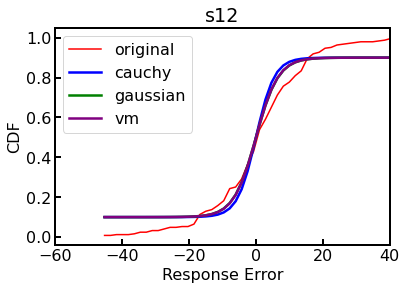

[0.40796667]
[-50.84 -48.68 -46.52 -44.36 -42.2  -40.04 -37.88 -35.72 -33.56 -31.4
 -29.24 -27.08 -24.92 -22.76 -20.6  -18.44 -16.28 -14.12 -11.96  -9.8
  -7.64  -5.48  -3.32  -1.16   1.     3.16   5.32   7.48   9.64  11.8
  13.96  16.12  18.28  20.44  22.6   24.76  26.92  29.08  31.24  33.4
  35.56  37.72  39.88  42.04  44.2   46.36  48.52  50.68  52.84  55.  ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02794074 0.07364963 0.1423055  0.23635942 0.35327179 0.4846676
 0.61793068 0.73987036 0.84068383 0.91622485 0.96777025 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


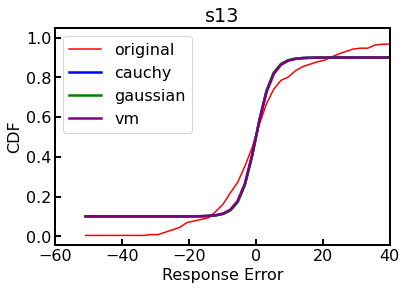

[0.50608926]
[-27.82003357 -26.64006714 -25.46010071 -24.28013428 -23.10016784
 -21.92020141 -20.74023498 -19.56026855 -18.38030212 -17.20033569
 -16.02036926 -14.84040283 -13.66043639 -12.48046996 -11.30050353
 -10.1205371   -8.94057067  -7.76060424  -6.58063781  -5.40067138
  -4.22070494  -3.04073851  -1.86077208  -0.68080565   0.49916078
   1.67912721   2.85909364   4.03906007   5.21902651   6.39899294
   7.57895937   8.7589258    9.93889223  11.11885866  12.29882509
  13.47879152  14.65875796  15.83872439  17.01869082  18.19865725
  19.37862368  20.55859011  21.73855654  22.91852297  24.09848941
  25.27845584  26.45842227  27.6383887   28.81835513  29.99832156]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0317974
 0.072812   0.123904   0.18530404 0.25642461 0.33576979 0.42098403
 0.50905214 0.59662509 0.68041238 0.75756255 0.82595713 0.88436725
 0.93245

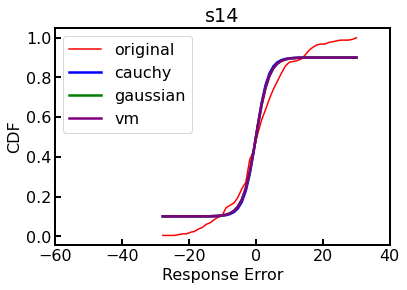

[0.43021274]
[-31.64 -30.28 -28.92 -27.56 -26.2  -24.84 -23.48 -22.12 -20.76 -19.4
 -18.04 -16.68 -15.32 -13.96 -12.6  -11.24  -9.88  -8.52  -7.16  -5.8
  -4.44  -3.08  -1.72  -0.36   1.     2.36   3.72   5.08   6.44   7.8
   9.16  10.52  11.88  13.24  14.6   15.96  17.32  18.68  20.04  21.4
  22.76  24.12  25.48  26.84  28.2   29.56  30.92  32.28  33.64  35.  ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.03318714
 0.07527051 0.12697019 0.18842008 0.25900684 0.33729623 0.42108162
 0.50756401 0.59364196 0.67625986 0.75274731 0.82108454 0.88004945
 0.92923245 0.96893636 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


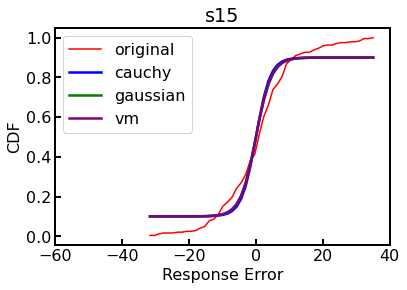

In [9]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_OG',  'JND_GAUSSIAN', 'JND_CAUCHY'])
n_bins=50
row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    jnd_og, jnd_gaussian, jnd_cauchy, jnd_vm = cdf_gaussian_cauchy(subjectdata['responseError'], title=subject)
    
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_OG'] = jnd_og[0]
    cdf_data.loc[row, 'JND_GAUSSIAN'] = jnd_gaussian[0]
    cdf_data.loc[row, 'JND_CAUCHY'] = jnd_cauchy[0]
    cdf_data.loc[row, 'JND_VM'] = jnd_vm[0]
    
    row += 1

(0.0, 7.0)

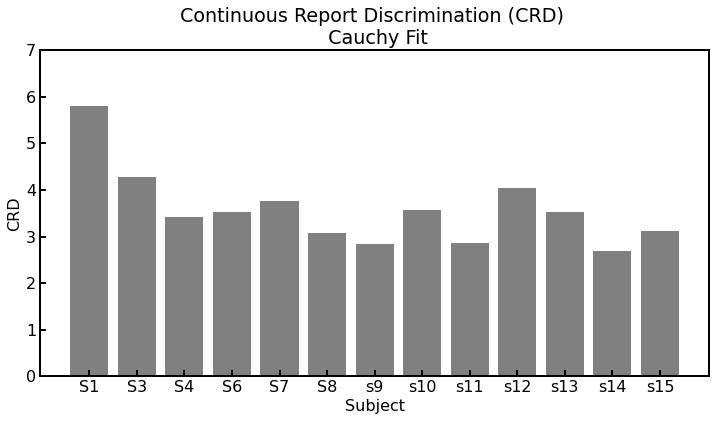

In [10]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CAUCHY'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Cauchy Fit')
plt.ylim([0, 7])

(0.0, 7.0)

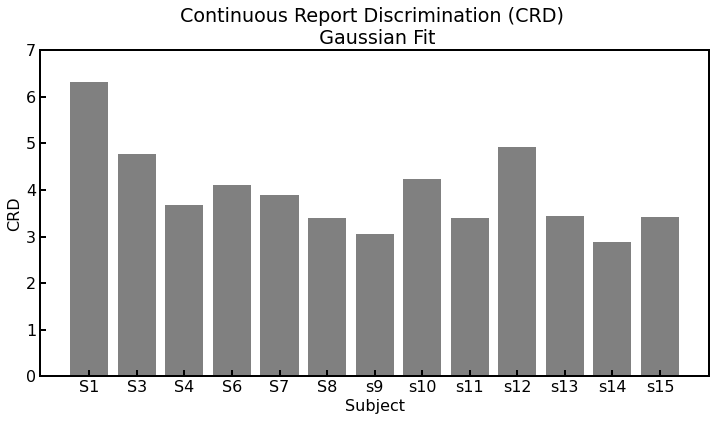

In [11]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_GAUSSIAN'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Gaussian Fit')
plt.ylim([0, 7])

In [12]:
np.median(cdf_data['JND_VM'])

3.68880430229433

In [13]:
np.median(cdf_data['JND_CAUCHY'])

3.525931967296774

In [14]:
np.median(cdf_data['JND_GAUSSIAN'])

3.678395537738509

(0.0, 7.0)

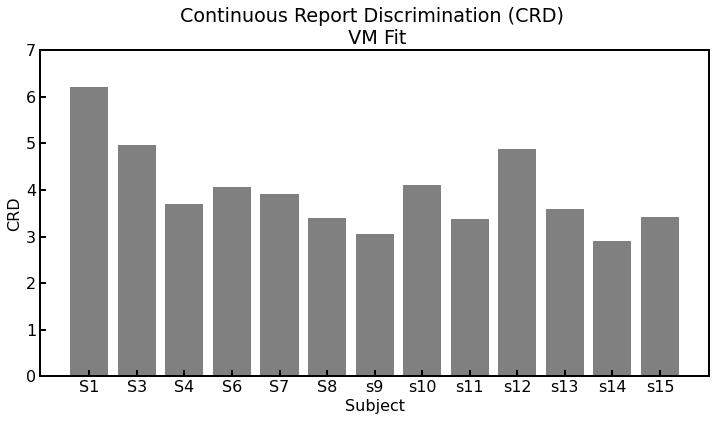

In [15]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_VM'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n VM Fit')
plt.ylim([0, 7])

In [16]:
good_cdf_data = cdf_data.copy()
good_cdf_data.loc[13, 'SUBJECT'] = 'mean'
good_cdf_data.loc[13, 'JND_OG'] = np.mean(good_cdf_data.loc[range(13), 'JND_OG'])
good_cdf_data.loc[13, 'JND_GAUSSIAN'] = np.mean(good_cdf_data.loc[range(13), 'JND_GAUSSIAN'])
good_cdf_data.loc[13, 'JND_CAUCHY'] = np.mean(good_cdf_data.loc[range(13), 'JND_CAUCHY'])
good_cdf_data.loc[13, 'JND_VM'] = np.mean(good_cdf_data.loc[range(13), 'JND_VM'])
good_cdf_data

,SUBJECT,JND_OG,JND_GAUSSIAN,JND_CAUCHY,JND_VM
0,S1,8.673952,6.311426,5.793501,6.204811
1,S3,7.588818,4.771203,4.267071,4.969217
2,S4,5.778005,3.678396,3.408895,3.688804
3,S6,5.661891,4.096918,3.525932,4.070500
4,S7,6.209854,3.896466,3.763245,3.910746
5,S8,5.357405,3.390229,3.083746,3.399725
6,s9,4.596893,3.048653,2.846495,3.052867
7,s10,5.880504,4.236462,3.575613,4.101082
8,s11,4.877245,3.386728,2.857995,3.379034
9,s12,6.62934,4.920103,4.037933,4.877542


In [17]:
jnd_vm_sem = stats.sem(good_cdf_data.loc[range(13), 'JND_VM'])
jnd_vm_sem

0.25380105923495533

In [18]:
jnd_vm_sem_all = [0]*13
jnd_vm_sem_all.append(jnd_vm_sem)
jnd_vm_sem_all

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25380105923495533]

Text(0.5, 1.0, 'Radiologists')

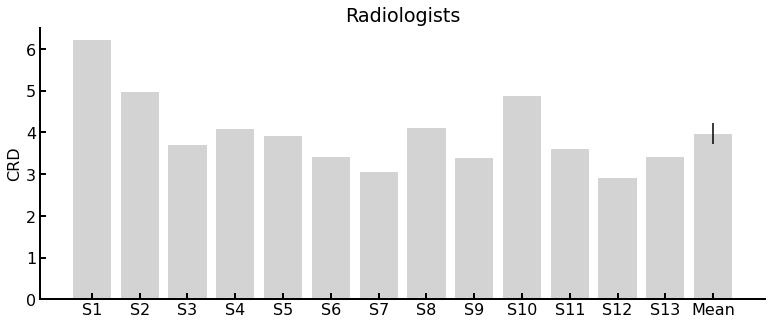

In [19]:
plt.figure(figsize=(13, 5))
ax = plt.bar(good_cdf_data['SUBJECT'], good_cdf_data['JND_VM'], color='lightgrey', yerr=jnd_vm_sem_all)
plt.ylabel('CRD')
plt.xticks(range(14), ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'Mean'])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Radiologists')


## Goodness of fit 

Here, yi refers to your input y-values, fi refers to your fitted y-values, and ̅y refers to the mean input y-value.

In [20]:
# residual sum of squares
def r2(x, y,  y_fit, title):
#     weight_param = 1/(abs(x)+1)
#     plt.plot((y - y_fit) ** 2)
#     plt.ylim([0, 2500])
#     plt.title(title)
#     plt.show()
    ss_res = np.sum(((y - y_fit) ** 2))
    
    # total sum of squares
    ss_tot = np.sum(((y - np.mean(y)) ** 2))

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def calculate_r2_subjects(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    counts_vm = vm(bin_edges[1:], *popt_vm)

    r2_fit_gaussian = r2(bin_edges[1:], counts, counts_cauchy, title+'Gaussian')
    r2_fit_cauchy = r2(bin_edges[1:], counts, counts_gaussian, title+'Cauchy')
    r2_fit_vm = r2(bin_edges[1:], counts, counts_vm, title+'VM')
    
    
    return r2_fit_gaussian, r2_fit_cauchy, r2_fit_vm

In [21]:
r2_data = pd.DataFrame(columns=['SUBJECT','R2_GAUSSIAN', 'R2_CAUCHY', 'R2_VM'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    r2_fit_gaussian, r2_fit_cauchy, r2_fit_vm= calculate_r2_subjects(subjectdata['responseError'], subject)
    
    r2_data.loc[row,'SUBJECT'] = subject
    r2_data.loc[row, 'R2_GAUSSIAN'] = r2_fit_gaussian
    r2_data.loc[row, 'R2_CAUCHY'] = r2_fit_cauchy
    r2_data.loc[row, 'R2_VM'] = r2_fit_vm
    
    
    row += 1

In [22]:
r2_data_melted = r2_data.melt(id_vars=['SUBJECT'], value_vars=['R2_GAUSSIAN','R2_CAUCHY', 'R2_VM'])

Text(0, 0.5, 'R2')

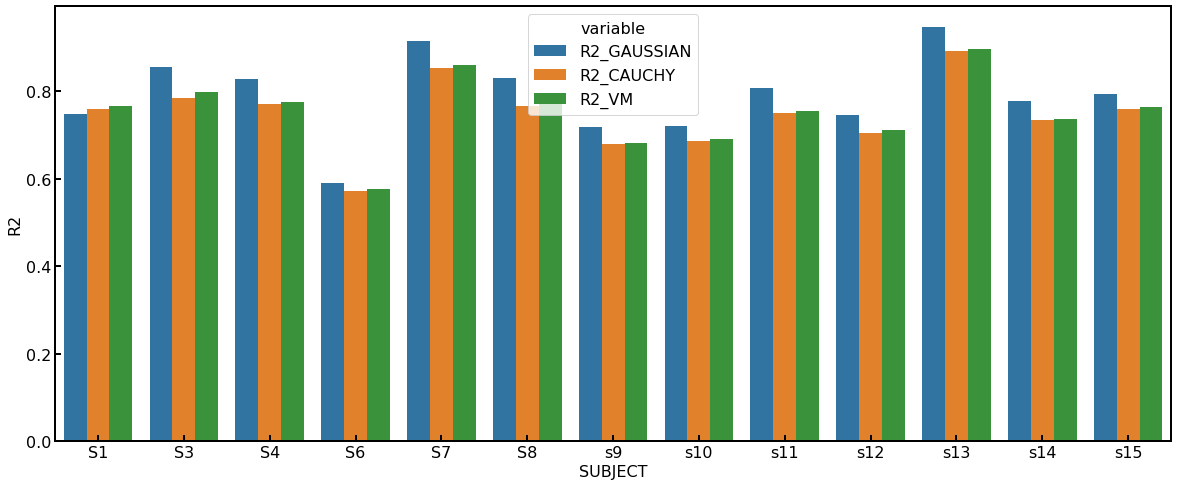

In [23]:
plt.figure(figsize=(20,8))
sns.barplot(x='SUBJECT', y='value', hue='variable', data=r2_data_melted)
plt.ylabel('R2')


## Comparing fits 

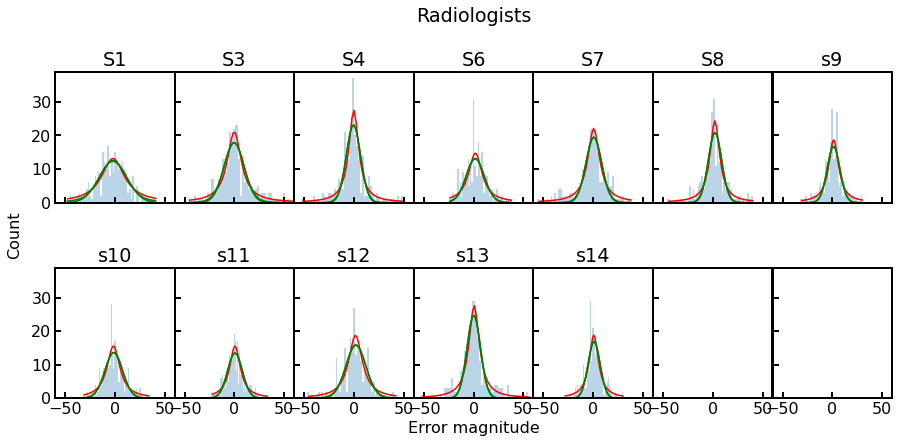

In [24]:
row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()

for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) 
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    axs[row].hist(subjectdata['responseError'], bins=n_bins, alpha=0.3)
    axs[row].plot(bin_edges[1:], cauchy(bin_edges[1:], *popt_cauchy), color='red', label='cauchy')
    axs[row].plot(bin_edges[1:], gaussian(bin_edges[1:], *popt_gaussian), color='green', label='gaussian')
    axs[row].plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='vm')
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
    axs[row].set_title(subject)
    
    if subject == 's15':
        axs[row].legend()
    
    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n');
# plt.legend()


# Category boundaries 

## Function definition

In [25]:
def vonmise_derivative(xdata, a = 25, kai = 4):
    xdata = xdata / 73 * np.pi
    return - a / (i0(kai) * 2 * np.pi) * exp(kai * cos(xdata)) * kai * sin(xdata) # Derivative of vonmise formula
def getRunningMean(stimuli_diff, filtered_responseError, halfway =74, step = 8):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

def getRegressionLine(x, y, peak):
    stimuli_diff_filtered = []
    filtered_responseError_new = []
    for i in range(len(x)):
        if x[i] < peak + 1 and x[i] > - peak + 1:
            stimuli_diff_filtered.append(x[i])
            filtered_responseError_new.append(y[i])
    coef = np.polyfit(stimuli_diff_filtered,filtered_responseError_new,1)
    poly1d_fn = np.poly1d(coef)
    return poly1d_fn, coef

In [26]:
def category_definition(morph):
    
    if (morph in range(124, 148)) or (morph in range(1, 26)):
        category = 'A'
    elif morph in range(26, 75):
        category = 'B'
    elif morph in range(75, 124):
        category = 'C'
        
    return category

## Empirical 

In [27]:
def amplitude_calc(data, title):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError'], p0=init_vals, bounds = ([-60,2],[60,4]))
    #### RUNNING MEAN ####
    RM, xvals = getRunningMean(data['Stim_diff'], data['responseError'], step = 20)

    plt.figure(figsize=(5, 4))
    plt.plot(data['Stim_diff'], data['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in data['Stim_diff']]
    plt.plot(x, y, '-', linewidth = 4, color='k')
    plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
    peak_x = (x[np.argmax(y)])
    poly1d_fn, coef = getRegressionLine(x = data['Stim_diff'], y= data['responseError'], peak = peak_x)
    xdata = np.linspace(-peak_x, peak_x, 100)
    plt.plot(xdata, poly1d_fn(xdata), linestyle='--', color='powderblue', linewidth = 4)
    plt.xlim([-73, 73])
    plt.ylim([-60, 60])
    plt.yticks(np.arange(-60, 70, 10))
    # plt.xticks(np.arange(-70, 80, 20))
    plt.xticks([-73, -50, -25, 0, 25, 50, 73])
    sns.despine()
    # print(coef[0], coef[1])
    plt.title('Current and previous\n ' + title)
    plt.ylabel('Response Error\n(morph units)')
    plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.eps', bbox_inches='tight', dpi=1200)
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.jpg', bbox_inches='tight', dpi=1200)
    plt.show()
    
    if x[np.argmax(y)] > 0: 
        amplitude = np.max(y)
    else: 
        amplitude = -np.max(y)
        
        
    return amplitude



/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


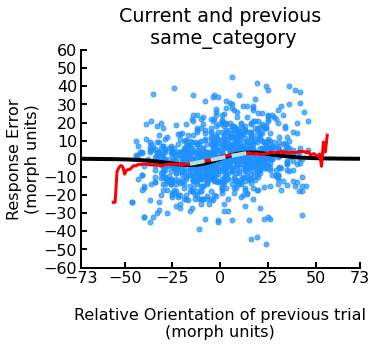

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


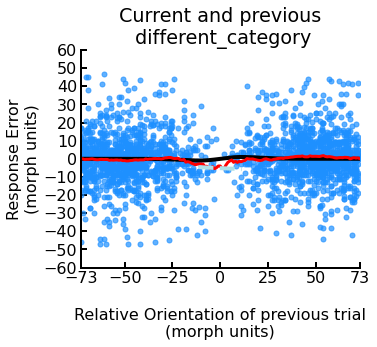

In [110]:
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)

same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
empirical_amp_same_category = amplitude_calc(same_category, 'same_category')
empirical_amp_diff_category = amplitude_calc(diff_category, 'different_category')

# all_category_emp = pd.DataFrame()
# all_category_emp.loc[0, 'NULL']='DIFFERENT'
# all_category_emp.loc[0, 'EMPIRICAL'] = empirical_amp_diff_category
# all_category_emp.loc[1, 'NULL']='SAME'
# all_category_emp.loc[1, 'EMPIRICAL'] = empirical_amp_same_category
    

In [29]:
# def slope_amp_calc(xdata, ydata):
#     ## Von Mise fitting: Shape Similarity##
#     init_vals = [-25, 4]
#     best_vals, covar = curve_fit(vonmise_derivative, xdata, ydata, p0=init_vals, bounds = ([-60,2],[60,4]))

#     x = np.linspace(-75, 75, 300)
#     y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
#     if x[np.argmax(y)] > 0: 
#         amp = np.max(y)
#     else: 
#         amp = -np.max(y)
# #     peak_x = (x[np.argmax(y)])
#     peak_x = 18

#     poly1d_fn, coef = getRegressionLine(x = xdata, y= ydata, peak = peak_x)

#     return coef[0], amp


# def init_bootstrap(xdata, ydata, nIterations=1000):
#     slope_boots = []
#     amp_boots = []
#     bsSize = int(1.0 * len(xdata))
#     iteration = 0
#     while len(slope_boots) < nIterations:
# #         print(iteration)
#         RandIndex = np.random.choice(len(xdata), bsSize, replace=True) # get randi index of xdata
#         xdataNEW = [xdata[i] for i in RandIndex] # change xdata index
#         ydataNEW = [ydata[i] for i in RandIndex] # change ydata index

#         try:
#             slope, amp = slope_amp_calc(xdataNEW, ydataNEW)
#             slope_boots.append(slope)
#             amp_boots.append(amp)
#             iteration += 1
#         except TypeError:
#             pass       

        
#     return slope_boots, amp_boots

# slopes = pd.DataFrame(columns=['SUBJECT', 'TYPE', 'SLOPE'])
# amps = pd.DataFrame(columns=['SUBJECT', 'TYPE', 'AMPLITUDE'])
# for subject in ['SuperSubject']: #subject_names:
#     print(subject)
#     tmp_same_slope = pd.DataFrame()
#     tmp_diff_slope = pd.DataFrame()
#     tmp_same_amp = pd.DataFrame()
#     tmp_diff_amp = pd.DataFrame()
#     # load data:
#     subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
#     subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
#     subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)
# #     alldata_slope, alldata_amp = init_bootstrap(np.asarray(subjectdata['Stim_diff']), np.asarray(subjectdata['responseError']))    
#     same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
#     diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
#     slope_same_cat, amp_same_cat = init_bootstrap(np.asarray(same_category['Stim_diff']), np.asarray(same_category['responseError']))
#     slope_diff_cat, amp_diff_cat = init_bootstrap(np.asarray(diff_category['Stim_diff']), np.asarray(diff_category['responseError']))    

#     tmp_same_slope['SLOPE'] = slope_same_cat
#     tmp_same_slope['SUBJECT'] = subject
#     tmp_same_slope['TYPE'] = 'SAME'    

#     tmp_same_amp['AMPLITUDE'] = amp_same_cat
#     tmp_same_amp['SUBJECT'] = subject
#     tmp_same_amp['TYPE'] = 'SAME'    

#     tmp_diff_slope['SLOPE'] = slope_diff_cat
#     tmp_diff_slope['SUBJECT'] = subject
#     tmp_diff_slope['TYPE'] = 'DIFFERENT'    

#     tmp_diff_amp['AMPLITUDE'] = amp_diff_cat
#     tmp_diff_amp['SUBJECT'] = subject
#     tmp_diff_amp['TYPE'] = 'DIFFERENT'
    
#     slopes = pd.concat([slopes, tmp_same_slope, tmp_diff_slope])
#     amps = pd.concat([amps, tmp_same_amp, tmp_diff_amp])

# # slopes.to_csv('slopes_boot.csv')
# # amps.to_csv('amps_boot.csv')

In [111]:
def slope_amp_calc(xdata, ydata):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, xdata, ydata, p0=init_vals, bounds = ([-60,2],[60,4]))

    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    if x[np.argmax(y)] > 0: 
        amp = np.max(y)
    else: 
        amp = -np.max(y)
#     peak_x = (x[np.argmax(y)])
    peak_x = 18

    poly1d_fn, coef = getRegressionLine(x = xdata, y= ydata, peak = peak_x)

    return coef[0], amp


def init_bootstrap(xdata, ydata, nIterations=5000):
    slope_boots = []
    amp_boots = []
    bsSize = int(1.0 * len(xdata))
    iteration = 0
    while len(slope_boots) < nIterations:
        print(iteration)
        RandIndex = np.random.choice(len(xdata), bsSize, replace=True) # get randi index of xdata
        xdataNEW = [xdata[i] for i in RandIndex] # change xdata index
        ydataNEW = [ydata[i] for i in RandIndex] # change ydata index

        try:
            slope, amp = slope_amp_calc(xdataNEW, ydataNEW)
            slope_boots.append(slope)
            amp_boots.append(amp)
            iteration += 1
        except TypeError:
            pass       

        
    return slope_boots, amp_boots

slopes_v1 = pd.DataFrame(columns=['TYPE', 'SLOPE'])
amps_v1 = pd.DataFrame(columns=['TYPE', 'AMPLITUDE'])

for subject in ['SuperSubject']: #subject_names:
    tmp_same_slope = pd.DataFrame()
    tmp_same_amp = pd.DataFrame()
    tmp_diff_slope = pd.DataFrame()
    tmp_diff_amp = pd.DataFrame()
    
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)

    same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
    diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
    slope_same_cat, amp_same_cat = init_bootstrap(np.asarray(same_category['Stim_diff']), np.asarray(same_category['responseError']))
    slope_diff_cat, amp_diff_cat = init_bootstrap(np.asarray(diff_category['Stim_diff']), np.asarray(diff_category['responseError']))    

    tmp_same_slope['SLOPE'] = slope_same_cat
    tmp_same_slope['TYPE'] = 'SAME'    

    tmp_same_amp['AMPLITUDE'] = amp_same_cat
    tmp_same_amp['TYPE'] = 'SAME'    

    tmp_diff_slope['SLOPE'] = slope_diff_cat
    tmp_diff_slope['TYPE'] = 'DIFFERENT'    

    tmp_diff_amp['AMPLITUDE'] = amp_diff_cat
    tmp_diff_amp['TYPE'] = 'DIFFERENT'    
    
    slopes_v1 = pd.concat([slopes_v1, tmp_same_slope, tmp_diff_slope])
    amps_v1 = pd.concat([amps_v1, tmp_same_amp, tmp_diff_amp])

# slopes_v1.to_csv('slopes_empirical_v1.csv')
# amps_v1.to_csv('amps_empirical_v1.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080


3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720


232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481


2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227


3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880


0.9436


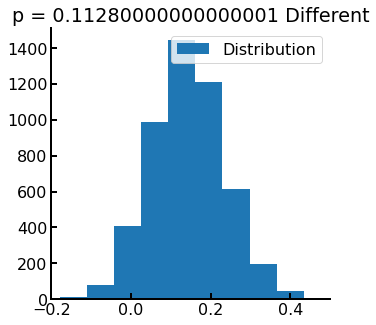

1.0


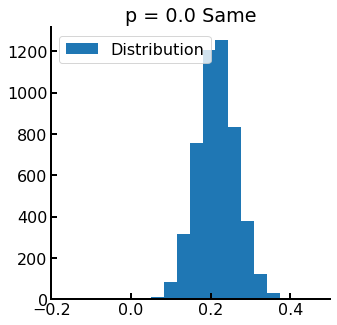

In [112]:
compDistributions.sigDistribution(slopes_v1[slopes_v1['TYPE']=='DIFFERENT']['SLOPE'], extra_title=' Different', xlim=[-0.2, 0.5])
compDistributions.sigDistribution(slopes_v1[slopes_v1['TYPE']=='SAME']['SLOPE'], extra_title=' Same', xlim=[-0.2, 0.5])


## Mauro's empirical 

In [ ]:
def slope_amp_calc_mauro(xdata, ydata):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, xdata, ydata, p0=init_vals, bounds = ([-60,2],[60,4]))

    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    if x[np.argmax(y)] > 0: 
        amp = np.max(y)
    else: 
        amp = -np.max(y)
#     peak_x = (x[np.argmax(y)])
    peak_x = 18

    poly1d_fn, coef = getRegressionLine(x = xdata, y= ydata, peak = peak_x)

    return coef[0], amp



slope_same_boots = []
amp_same_boots = []
slope_diff_boots = []
amp_diff_boots = []

tmp_same_slope = pd.DataFrame()
tmp_same_amp = pd.DataFrame()
tmp_diff_slope = pd.DataFrame()
tmp_diff_amp = pd.DataFrame()

slopes_mauro = pd.DataFrame(columns=['TYPE', 'SLOPE'])
amps_mauro = pd.DataFrame(columns=['TYPE', 'AMPLITUDE'])

nIterations = 5000
for iteration in range(nIterations):
    print(iteration)
    bsSize = int(1.0 * len(subject_names))
    RandIndex = np.random.choice(len(subject_names), bsSize, replace=True)
    subject_namesNEW = [subject_names[i] for i in RandIndex]
    supersubject = pd.DataFrame()
    for subject in subject_namesNEW:
            subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
            subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
            supersubject = pd.concat([supersubject, subjectdata])
    
    supersubject['same_category'] = supersubject['stimulusID'].apply(category_definition) == supersubject['shifted_stimulusID'].apply(category_definition)
    same_category = supersubject[supersubject['same_category'] == True].reset_index(drop=True)
    diff_category = supersubject[supersubject['same_category'] == False].reset_index(drop=True)
    slope_same, amplitude_same = slope_amp_calc_mauro(np.asarray(same_category['Stim_diff']), np.asarray(same_category['responseError']))
    slope_diff, amplitude_diff = slope_amp_calc_mauro(np.asarray(diff_category['Stim_diff']), np.asarray(diff_category['responseError']))
    
    slope_same_boots.append(slope_same)
    amp_same_boots.append(amplitude_same)
    slope_diff_boots.append(slope_diff)
    amp_diff_boots.append(amplitude_diff)

tmp_same_slope['SLOPE'] = slope_same_boots
tmp_same_slope['TYPE'] = 'SAME'    

tmp_same_amp['AMPLITUDE'] = amp_same_boots
tmp_same_amp['TYPE'] = 'SAME'    

tmp_diff_slope['SLOPE'] = slope_diff_boots
tmp_diff_slope['TYPE'] = 'DIFFERENT'    

tmp_diff_amp['AMPLITUDE'] = amp_diff_boots
tmp_diff_amp['TYPE'] = 'DIFFERENT'    

slopes_mauro = pd.concat([slopes_mauro, tmp_same_slope, tmp_diff_slope])
amps_mauro = pd.concat([amps_mauro, tmp_same_amp, tmp_diff_amp])

slopes_mauro.to_csv('slopes_empirical_mauro.csv')
amps_mauro.to_csv('amps_empirical_mauro.csv')

In [ ]:
compDistributions.sigDistribution(slopes_mauro[slopes_mauro['TYPE']=='DIFFERENT']['SLOPE'], extra_title=' Different', xlim=[-0.2, 0.5])
compDistributions.sigDistribution(slopes_mauro[slopes_mauro['TYPE']=='SAME']['SLOPE'], extra_title=' Same', xlim=[-0.2, 0.5])


In [ ]:

ax = sns.violinplot(x='TYPE', y='SLOPE', data=slopes_mauro)
for violin, alpha in zip(ax.collections[::2], [0.2, 0.2]):
    violin.set_alpha(alpha)
    
# sns.swarmplot(ax=ax, x='NULL', y='EMPIRICAL', data=all_category_emp, size=10)
plt.xlabel('')
plt.ylabel('Slope')
plt.ylim([-0.25, 0.5])

plt.title('Empirical slopes\nsame and different category\n Mauro version')

In [ ]:

ax = sns.violinplot(x='TYPE', y='SLOPE', data=slopes_v1)
for violin, alpha in zip(ax.collections[::2], [0.2, 0.2]):
    violin.set_alpha(alpha)
    
# sns.swarmplot(ax=ax, x='NULL', y='EMPIRICAL', data=all_category_emp, size=10)
plt.xlabel('')
plt.ylabel('Slope')
plt.ylim([-0.25, 0.5])
plt.title('Empirical slopes\nsame and different category\n version 1')

## Null good

In [113]:
def init_null(data, subject, nIterations=5000):
    data_null = pd.DataFrame(columns=['ITERATION', 'SUBJECT', 'TYPE', 'AMPLITUDE', 'SLOPE'])
    row = 0
    data['Stim_diff_og'] = data['Stim_diff']
    amp_same_arr = []
    amp_diff_arr = []
    slope_same_arr = []
    slope_diff_arr = []
    init_vals = [-25, 1.5]

    for iteration in range(nIterations):
#         print(iteration)
        
        data['Stim_diff'] = data['Stim_diff_og'].sample(frac=1).reset_index(drop=True)

        data['same_category'] = data['stimulusID'].apply(category_definition) == data['shifted_stimulusID'].apply(category_definition)

        same_category = data[data['same_category'] == True].reset_index(drop=True)
        diff_category = data[data['same_category'] == False].reset_index(drop=True)

        try: 
            best_vals, covar = curve_fit(vonmise_derivative, diff_category['Stim_diff'], diff_category['responseError']) #,p0=init_vals, bounds= ([-60,1],[60, 1.5]))
    #         print('best_vals', best_vals)
            x = np.linspace(-75, 75, 1000)
            y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]


            if x[np.argmax(y)] > 0: 
                amplitude = np.max(y)
            else: 
                amplitude = -np.max(y)

#             peak_x = (x[np.argmax(y)])
            peak_x = 18
#             print('amplitude different:', amplitude)

            amp_diff_arr.append(amplitude)
            poly1d_fn, coef = getRegressionLine(x = diff_category['Stim_diff'].values, y= diff_category['responseError'].values, peak = abs(peak_x))
            slope_diff_arr.append(coef[0])
    #         print('slope:', coef[0])

#             ### plot
#             RM, xvals = getRunningMean(diff_category['Stim_diff'], diff_category['responseError'], step = 20)

#             plt.figure(figsize=(5, 4))
#             plt.plot(diff_category['Stim_diff'], diff_category['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
#             DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in diff_category['Stim_diff']]
#             plt.plot(x, y, '-', linewidth = 4, color='k')
#             plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
#             xdata = np.linspace(-peak_x, peak_x, 100)
#             plt.plot(xdata, poly1d_fn(xdata), linestyle='--', color='powderblue', linewidth = 4)
#             plt.xlim([-73, 73])
#             plt.ylim([-60, 60])
#             plt.yticks(np.arange(-60, 70, 10))
#             # plt.xticks(np.arange(-70, 80, 20))
#             plt.xticks([-73, -50, -25, 0, 25, 50, 73])
#             sns.despine()
#             # print(coef[0], coef[1])
#             plt.title('Current and previous\n ' + 'DIFFERENT CATEGORY\n iteration' + str(iteration) + 'amplitude: ' + str((amplitude)))    
#             plt.show()
        except:
            pass

        
        
        
        ###



        try:
            best_vals, covar = curve_fit(vonmise_derivative, same_category['Stim_diff'], same_category['responseError']) #,p0=init_vals)
    #         print('best_vals', best_vals)
            x = np.linspace(-75, 75, 1000)
            y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]


            if x[np.argmax(y)] > 0: 
                amplitude = np.max(y)
            else: 
                amplitude = -np.max(y)

#             peak_x = (x[np.argmax(y)])
            peak_x = 18
            amp_same_arr.append(amplitude)
#             print('amplitude same:', amplitude)

            poly1d_fn, coef = getRegressionLine(x = same_category['Stim_diff'].values, y= same_category['responseError'].values, peak = abs(peak_x))

            slope_same_arr.append(coef[0])
#             print('slope same:', coef[0])

#             ### plot
#             RM, xvals = getRunningMean(same_category['Stim_diff'], same_category['responseError'], step = 20)

#             plt.figure(figsize=(5, 4))
#             plt.plot(same_category['Stim_diff'], same_category['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
#             DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in same_category['Stim_diff']]
#             plt.plot(x, y, '-', linewidth = 4, color='k')
#             plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
#             xdata = np.linspace(-peak_x, peak_x, 100)
#             plt.plot(xdata, poly1d_fn(xdata), linestyle='--', color='powderblue', linewidth = 4)
#             plt.xlim([-73, 73])
#             plt.ylim([-60, 60])
#             plt.yticks(np.arange(-60, 70, 10))
#             # plt.xticks(np.arange(-70, 80, 20))
#             plt.xticks([-73, -50, -25, 0, 25, 50, 73])
#             sns.despine()
#             # print(coef[0], coef[1])
#             plt.title('Current and previous\n ' + 'SAME CATEGORY\n iteration' + str(iteration) + 'amplitude: ' + str((amplitude)))    
#             plt.show()
        except:
            pass
        
        
        
        
        
        ###


        
    return amp_diff_arr, slope_diff_arr, amp_same_arr, slope_same_arr




In [114]:
amp_nulls = pd.DataFrame()
slope_nulls = pd.DataFrame()
for subject in ['SuperSubject']:
    print(subject)
    tmp_amp_same = pd.DataFrame()
    tmp_amp_diff = pd.DataFrame()
    tmp_slope_same = pd.DataFrame()
    tmp_slope_diff = pd.DataFrame()
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
 
    amp_diff_arr, slope_diff_arr, amp_same_arr, slope_same_arr = init_null(subjectdata, subject, 5000)
    tmp_amp_same['NULL'] = amp_same_arr
    tmp_amp_same['TYPE'] = 'SAME'
    tmp_amp_same['SUBJECT'] = subject
    
    tmp_amp_diff['NULL'] = amp_diff_arr
    tmp_amp_diff['TYPE'] = 'DIFF'  
    tmp_amp_diff['SUBJECT'] = subject

    
    tmp_slope_same['NULL'] = slope_same_arr
    tmp_slope_same['TYPE'] = 'SAME'
    tmp_slope_same['SUBJECT'] = subject

    tmp_slope_diff['NULL'] = slope_diff_arr
    tmp_slope_diff['TYPE'] = 'DIFF'      
    tmp_slope_diff['SUBJECT'] = subject
    
    amp_nulls = pd.concat([amp_nulls, tmp_amp_diff, tmp_amp_same])
    slope_nulls = pd.concat([slope_nulls, tmp_slope_diff, tmp_slope_same])
#     slope_nulls.to_csv('slope_backup_nulls.csv')
#     amp_nulls.to_csv('amp_backup_nulls.csv')

SuperSubject


/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: Optim

Text(0.5, 1.0, 'Null slopes\nsame and different category\n')

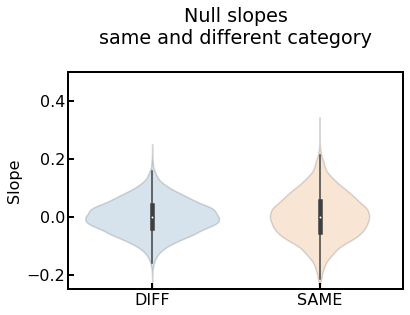

In [115]:

ax = sns.violinplot(x='TYPE', y='NULL', data=slope_nulls)
for violin, alpha in zip(ax.collections[::2], [0.2, 0.2]):
    violin.set_alpha(alpha)
    
# sns.swarmplot(ax=ax, x='NULL', y='EMPIRICAL', data=all_category_emp, size=10)
plt.xlabel('')
plt.ylabel('Slope')
plt.ylim([-0.25, 0.5])
plt.title('Null slopes\nsame and different category\n')

Text(0.5, 1.0, 'null half amplitudes\nsame and different category')

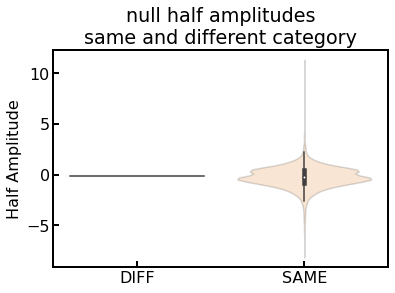

In [116]:

ax = sns.violinplot(x='TYPE', y='NULL', data=amp_nulls)
for violin, alpha in zip(ax.collections[::2], [0.2, 0.2]):
    violin.set_alpha(alpha)
    
plt.xlabel('')
plt.ylabel('Half Amplitude')
plt.title('null half amplitudes\nsame and different category')

In [118]:
nIterations = 5000
sorted_null_diff = sorted(slope_nulls.loc[slope_nulls['TYPE'] == 'DIFF', 'NULL'])
ci97_null_diff = sorted_null_diff[int(nIterations*0.97)]
ci97_null_diff

0.11269989031379798

In [119]:
sorted_null_same = sorted(slope_nulls.loc[slope_nulls['TYPE'] == 'SAME', 'NULL'])
ci97_null_same = sorted_null_same[int(nIterations*0.97)]
ci97_null_same

0.1508265546632049

In [120]:
def calc_p(data, empirical):
    p = sum(data['NULL'] < empirical)/len(data)
    if p < .5:
        twoTailedP = p * 2;
    else:
        twoTailedP = (1 - p) * 2;
    return twoTailedP
empirical_amp_same_category = np.mean(slopes_v1[slopes_v1['TYPE'] == 'SAME']['SLOPE'])
empirical_amp_diff_category =  np.mean(slopes_v1[slopes_v1['TYPE'] == 'DIFFERENT']['SLOPE'])
p_same = calc_p(slope_nulls[slope_nulls['TYPE'] == 'SAME'], empirical_amp_same_category)
p_diff = calc_p(slope_nulls[slope_nulls['TYPE'] == 'DIFF'], empirical_amp_diff_category)
p_same, p_diff

(0.006402561024409836, 0.018799999999999928)

#  Figure CRD

In [31]:
good_cdf_data = cdf_data.copy()
good_cdf_data.loc[13, 'SUBJECT'] = 'mean'
good_cdf_data.loc[13, 'JND_OG'] = np.mean(good_cdf_data.loc[range(13), 'JND_OG'])
good_cdf_data.loc[13, 'JND_GAUSSIAN'] = np.mean(good_cdf_data.loc[range(13), 'JND_GAUSSIAN'])
good_cdf_data.loc[13, 'JND_CAUCHY'] = np.mean(good_cdf_data.loc[range(13), 'JND_CAUCHY'])
good_cdf_data.loc[13, 'JND_VM'] = np.mean(good_cdf_data.loc[range(13), 'JND_VM'])
good_cdf_data
jnd_vm_sem = stats.sem(good_cdf_data.loc[range(13), 'JND_VM'])
jnd_vm_sem
jnd_vm_sem_all = [0]*13
jnd_vm_sem_all.append(jnd_vm_sem)
jnd_vm_sem_all

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25380105923495533]

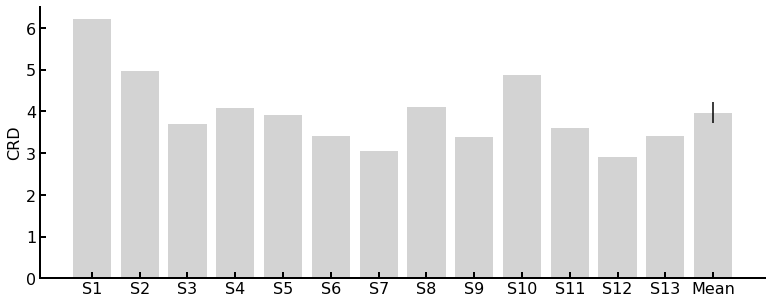

In [32]:
plt.figure(figsize=(13, 5))
ax = plt.bar(good_cdf_data['SUBJECT'], good_cdf_data['JND_VM'], color='lightgrey', yerr=jnd_vm_sem_all)
plt.ylabel('CRD')
plt.xticks(range(14), ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'Mean'])
sns.despine(top=True, right=True, left=False, bottom=False)


In [33]:
good_cdf_data.to_csv('cdf_radiologists.csv')

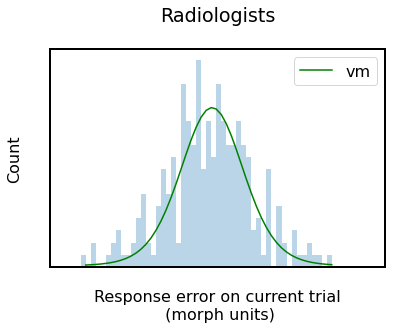

In [34]:
# row = 0
# fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
# fig.subplots_adjust(hspace = .5, wspace=.001)
# fig.add_subplot(111, frameon=False)

# axs = axs.ravel()

# for subject in subject_names_wsuper:
subject='S1'
# load data:
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
counts[counts < 5] = 0

popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) 
popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
plt.hist(subjectdata['responseError'], bins=n_bins, alpha=0.3)
plt.plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='vm')
plt.xlabel('')
plt.ylabel('')
plt.xlim([-60, 60])
plt.title(subject)

plt.legend()
    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Response error on current trial\n (morph units)')
plt.ylabel('Count')
plt.title('Radiologists\n');
# plt.legend()


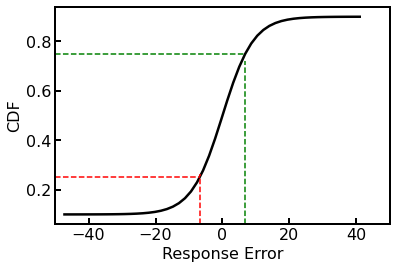

In [35]:
subject='S1'
# load data:
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
cdf_vm, cdf_filtered_vm, counts_vm_filtered = cdf(counts)


bestvals_vm, temp_vm = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_vm,p0=[3])
cdf_og, cdf_filtered_og, counts_filtered_og = cdf(counts)


perc_25_vm = inverse_sigmoid(0.25, bestvals_vm)
perc_75_vm = inverse_sigmoid(0.75, bestvals_vm)    

# plt.plot(bin_edges[1:], cdf_og, color='darkgrey', linewidth=1, label='CDF')

plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_vm), color='black', linewidth=2.5)

plt.axvline(perc_25_vm, 0, 0.23, color='red', linestyle='--')
plt.axvline(perc_75_vm, 0, 0.75, color='green', linestyle='--')

low_limit = -50
plt.axhline(0.25, 0, (np.abs(low_limit) - np.abs(perc_25_vm))/100, color='red', linestyle='--')
# plt.axhline(0.75, 0, ((60 - np.abs(perc_25_vm))/100) + (perc_75_vm/100), color='green', linestyle='--')
plt.axhline(0.75, 0, ((np.abs(low_limit) + np.abs(perc_75_vm))/100), color='green', linestyle='--')

plt.xlim([low_limit, 50])
plt.ylabel('CDF')
plt.xlabel('Response Error')
# plt.legend()
# plt.title(title)
plt.show()
    

<ipython-input-36-49e9faaf079f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '   Mean'])


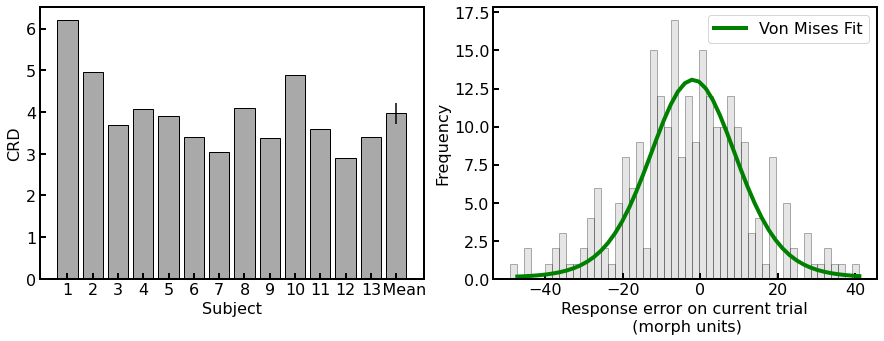

In [36]:
row = 0
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.18)
# fig.add_subplot(111, frameon=False)

# axs = axs.ravel()

axs[0].bar(good_cdf_data['SUBJECT'], good_cdf_data['JND_VM'], color='darkgrey', yerr=jnd_vm_sem_all, edgecolor='black')
axs[0].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '   Mean'])
axs[0].set_ylabel('CRD')
axs[0].set_xlabel('Subject')

axs[1].hist(subjectdata['responseError'], bins=n_bins, alpha=0.3, color='darkgrey', edgecolor='black')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Response error on current trial\n (morph units)')
axs[1].plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='Von Mises Fit', linewidth=4)
axs[1].legend()

# Figure slopes 

In [37]:
# slopes = pd.read_csv('slopes_boot.csv', index_col=0)
slopes = pd.read_csv('slopes_boot.csv', index_col=0)

In [38]:
slopes_same_pivoted = pd.DataFrame()
slopes_diff_pivoted = pd.DataFrame()
for subject in slopes.SUBJECT.unique():
    slopes_same_pivoted[subject] = slopes[(slopes['TYPE'] == 'SAME') & (slopes['SUBJECT'] == subject)]['SLOPE']
    slopes_diff_pivoted[subject] = slopes[(slopes['TYPE'] == 'DIFFERENT') & (slopes['SUBJECT'] == subject)]['SLOPE']
    


In [39]:
mean_bootstrap = pd.DataFrame()
mean_bootstrap.loc[0, 'MEAN_BOOT'] = np.mean(slopes_same_pivoted.mean(axis=1))
mean_bootstrap.loc[0, 'TYPE'] = 'SAME'
mean_bootstrap.loc[1, 'MEAN_BOOT'] = np.mean(slopes_diff_pivoted.mean(axis=1))
mean_bootstrap.loc[1, 'TYPE'] = 'DIFFERENT'
mean_bootstrap

,MEAN_BOOT,TYPE
0,0.279927,SAME
1,0.417823,DIFFERENT


In [40]:
subject_means_slopes_diff = slopes_diff_pivoted.mean(axis=0).to_frame().reset_index()
subject_means_slopes_diff['TYPE'] = 'DIFFERENT'
subject_means_slopes_same = slopes_same_pivoted.mean(axis=0).to_frame().reset_index()
subject_means_slopes_same['TYPE'] = 'SAME'
pd.concat([subject_means_slopes_diff, subject_means_slopes_same])
           
           

,index,0,TYPE
0,S1,1.871956,DIFFERENT
1,S3,-0.111432,DIFFERENT
2,S4,1.545985,DIFFERENT
3,S6,0.934605,DIFFERENT
4,S7,0.105457,DIFFERENT
5,S8,-0.991095,DIFFERENT
6,s9,-0.067386,DIFFERENT
7,s10,1.593517,DIFFERENT
8,s11,-0.084553,DIFFERENT
9,s12,-0.216771,DIFFERENT


# Pull across category

In [41]:
def category_definition(morph):
    
    if (morph in range(124, 148)) or (morph in range(1, 26)):
        category = 'A'
    elif morph in range(26, 75):
        category = 'B'
    elif morph in range(75, 124):
        category = 'C'
        
    return category

In [328]:
subject = 'SuperSubject'
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)


In [43]:
subjectdata.head()

,stimulusID,morphID,RT,trialNumber,blockNumber,stimLocationDeg,shifted_stimulusID,shifted_stimLocationDeg,shifted_morphID,Error,responseError,Stim_diff,Stim_Loc_diff,bootstrap_values,Running_Mean,slopes,intercepts,DoVM,same_category
0,67.0,72.0,2.899034,1.0,1.0,199.0,58.0,0.0,70.0,12.0,15.591656,9.0,-161.0,2.601034,0.172058,0.193816,0.097387,-5.299618e-17,True
1,58.0,70.0,2.149815,2.0,1.0,0.0,57.0,331.0,76.0,19.0,19.001205,1.0,29.0,1.652953,0.127298,0.173817,-0.234304,-1.863737e-02,True
2,133.0,78.0,4.315844,4.0,1.0,235.0,135.0,277.0,143.0,8.0,7.999045,-2.0,-42.0,2.142701,-0.017763,0.182917,-0.651661,-3.735816e-02,True
3,135.0,143.0,3.183391,5.0,1.0,277.0,127.0,29.0,144.0,17.0,17.000000,8.0,-112.0,2.411862,-0.109145,0.224286,0.402723,-5.624599e-02,True
4,127.0,144.0,1.099883,6.0,1.0,29.0,25.0,171.0,26.0,1.0,1.000000,-44.0,-142.0,1.778877,-0.252766,0.110848,-0.099127,-7.538492e-02,True


In [329]:
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)


In [171]:
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
y = np.asarray(diff_category['responseError'])
x = np.asarray(diff_category['Stim_diff'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')
            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            else:
                color.append('gray')


            
diff_category.loc[:, 'eff'] = color
len(color) == len(y)  
            

True

In [172]:
diff_category

,stimulusID,morphID,RT,trialNumber,blockNumber,stimLocationDeg,shifted_stimulusID,shifted_stimLocationDeg,shifted_morphID,Error,responseError,Stim_diff,Stim_Loc_diff,bootstrap_values,Running_Mean,slopes,intercepts,DoVM,same_category,eff
0,25.0,26.0,4.300511,7.0,1.0,171.0,101.0,160.0,104.0,3.0,2.000979,70.0,11.0,NaN,-0.352360,NaN,NaN,-0.094860,False,gray
1,101.0,104.0,11.382901,8.0,1.0,160.0,131.0,301.0,140.0,9.0,9.000000,-30.0,-141.0,NaN,-0.448567,NaN,NaN,-0.114756,False,gray
2,5.0,5.0,3.316789,10.0,1.0,67.0,122.0,82.0,12.0,36.0,36.000000,29.0,-15.0,NaN,-0.585864,NaN,NaN,-0.156158,False,magenta
3,108.0,112.0,3.232712,12.0,1.0,89.0,126.0,350.0,111.0,-15.0,-15.000000,-18.0,99.0,NaN,-0.770244,NaN,NaN,-0.200297,False,gray
4,126.0,111.0,3.763752,13.0,1.0,350.0,30.0,187.0,32.0,2.0,2.000000,-50.0,163.0,NaN,-0.635140,NaN,NaN,-0.223618,False,gray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,47.0,55.0,2.315794,77.0,3.0,15.0,8.0,296.0,7.0,-1.0,-1.000000,39.0,79.0,NaN,NaN,NaN,NaN,NaN,False,gray
2135,8.0,7.0,1.885999,78.0,3.0,296.0,36.0,130.0,31.0,-5.0,-5.000000,-28.0,166.0,NaN,NaN,NaN,NaN,NaN,False,gray
2136,37.0,44.0,1.299518,81.0,3.0,132.0,122.0,250.0,117.0,-5.0,-5.000000,61.0,-118.0,NaN,NaN,NaN,NaN,NaN,False,gray
2137,76.0,81.0,3.432437,83.0,3.0,205.0,147.0,140.0,7.0,6.0,6.000000,-71.0,65.0,NaN,NaN,NaN,NaN,NaN,False,gray


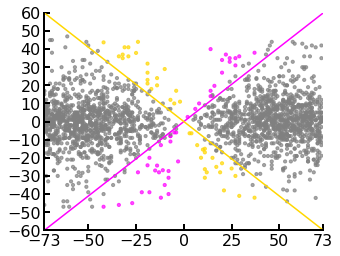

In [173]:
# plt.figure(figsize=(5, 4))
f, ax = plt.subplots(figsize=(5, 4))

ax.scatter(diff_category['Stim_diff'], diff_category['responseError'], c=diff_category['eff'], alpha = 0.7, marker='o', s=10)
plt.xlim([-73, 73])
plt.ylim([-60, 60])
plt.yticks(np.arange(-60, 70, 10))
# plt.xticks(np.arange(-70, 80, 20))
plt.xticks([-73, -50, -25, 0, 25, 50, 73])
sns.despine()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='magenta')
ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='gold')

# plt.plot([0, 1], [0, 1])
# plt.show()#, transform=ax.transAxes)


Text(0.5, 0, '\nRelative Orientation of previous trial\n(morph units)')

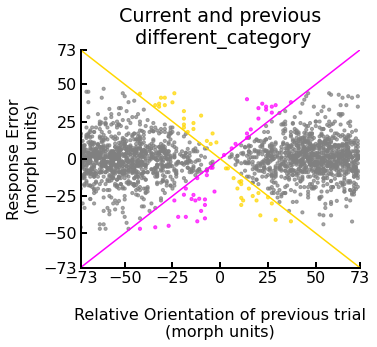

In [174]:
# plt.figure(figsize=(5, 4))
f, ax = plt.subplots(figsize=(5, 4))

ax.scatter(diff_category['Stim_diff'], diff_category['responseError'], c=diff_category['eff'], alpha = 0.7, marker='o', s=10)
plt.xlim([-73, 73])
plt.ylim([-73, 73])
# plt.yticks(np.arange(-73, 83, 10))
# plt.xticks(np.arange(-70, 80, 20))
plt.yticks([-73, -50, -25, 0, 25, 50, 73])
plt.xticks([-73, -50, -25, 0, 25, 50, 73])
sns.despine()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='magenta')
ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='gold')
plt.title('Current and previous\n ' + 'different_category')
plt.ylabel('Response Error\n(morph units)')
plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
# plt.plot([0, 1], [0, 1])
# plt.show()#, transform=ax.transAxes)


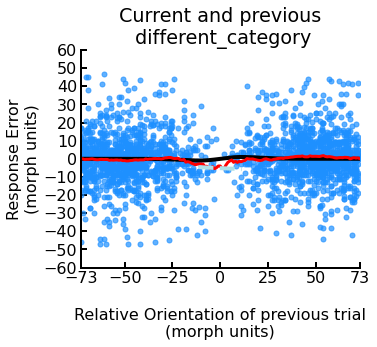

In [109]:
## Von Mise fitting: Shape Similarity##
init_vals = [-25, 4]
best_vals, covar = curve_fit(vonmise_derivative, diff_category['Stim_diff'], diff_category['responseError'], p0=init_vals, bounds = ([-60,2],[60,4]))
#### RUNNING MEAN ####
RM, xvals = getRunningMean(diff_category['Stim_diff'], diff_category['responseError'], step = 20)

plt.figure(figsize=(5, 4))
plt.plot(diff_category['Stim_diff'], diff_category['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
x = np.linspace(-75, 75, 300)
y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in diff_category['Stim_diff']]
plt.plot(x, y, '-', linewidth = 4, color='k')
plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
peak_x = (x[np.argmax(y)])
poly1d_fn, coef = getRegressionLine(x = diff_category['Stim_diff'], y= diff_category['responseError'], peak = peak_x)
xdiff_category = np.linspace(-peak_x, peak_x, 100)
plt.plot(xdiff_category, poly1d_fn(xdiff_category), linestyle='--', color='powderblue', linewidth = 4)
plt.xlim([-73, 73])
plt.ylim([-60, 60])
plt.yticks(np.arange(-60, 70, 10))
# plt.xticks(np.arange(-70, 80, 20))
plt.xticks([-73, -50, -25, 0, 25, 50, 73])
sns.despine()
# print(coef[0], coef[1])
plt.title('Current and previous\n ' + 'different_category')
plt.ylabel('Response Error\n(morph units)')
plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')

plt.show()

In [175]:
total_dots = len(y)
pink_dots = len(diff_category[diff_category['eff'] == 'magenta'])
yellow_dots = len(diff_category[diff_category['eff'] == 'gold'])
print('Number of total points:', total_dots)
print('Number of pink points:', pink_dots)
print('Number of yellow points:', yellow_dots)

Number of total points: 2139
Number of pink points: 40
Number of yellow points: 40


In [126]:
np.sum((diff_category['Stim_diff'] >= -25) & (diff_category['Stim_diff'] <= 25))

275

Number of total points: 275
Number of pink points: 33
Number of yellow points: 30


/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


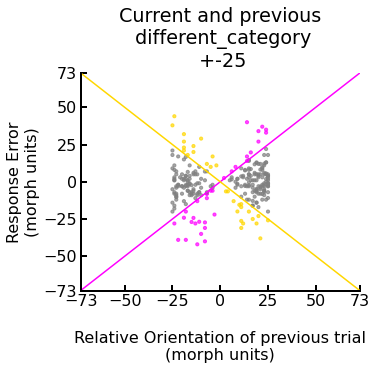

In [129]:
plusminus25 = diff_category[(diff_category['Stim_diff'] >= -25) & (diff_category['Stim_diff'] <= 25)]
y = np.asarray(plusminus25['responseError'])
x = np.asarray(plusminus25['Stim_diff'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')
            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            else:
                color.append('gray')

plusminus25.loc[:, 'eff'] = color
len(color) == len(y)  
            
# plt.figure(figsize=(5, 4))
f, ax = plt.subplots(figsize=(5, 4))

ax.scatter(plusminus25['Stim_diff'], plusminus25['responseError'], c=plusminus25['eff'], alpha = 0.7, marker='o', s=10)
plt.xlim([-73, 73])
plt.ylim([-73, 73])
# plt.yticks(np.arange(-73, 83, 10))
# plt.xticks(np.arange(-70, 80, 20))
plt.yticks([-73, -50, -25, 0, 25, 50, 73])
plt.xticks([-73, -50, -25, 0, 25, 50, 73])
sns.despine()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='magenta')
ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='gold')
plt.title('Current and previous\n ' + 'different_category\n +-25')
plt.ylabel('Response Error\n(morph units)')
plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')


    
total_dots = len(y)
pink_dots = len(plusminus25[plusminus25['eff'] == 'magenta'])
yellow_dots = len(plusminus25[plusminus25['eff'] == 'gold'])
print('Number of total points:', total_dots)
print('Number of pink points:', pink_dots)
print('Number of yellow points:', yellow_dots)
            

In [133]:
plusminus25[['Stim_diff', 'responseError']].to_csv('plusminus25_data.csv', index=False)

In [131]:
len(plusminus25)

275

In [132]:
plusminus25.head()

,stimulusID,morphID,RT,trialNumber,blockNumber,stimLocationDeg,shifted_stimulusID,shifted_stimLocationDeg,shifted_morphID,Error,responseError,Stim_diff,Stim_Loc_diff,bootstrap_values,Running_Mean,slopes,intercepts,DoVM,same_category,eff
3,108.0,112.0,3.232712,12.0,1.0,89.0,126.0,350.0,111.0,-15.0,-15.000000,-18.0,99.0,NaN,-0.770244,NaN,NaN,-0.200297,False,gray
16,23.0,25.0,4.416986,33.0,1.0,66.0,33.0,227.0,35.0,2.0,2.000236,-10.0,-161.0,NaN,-0.942053,NaN,NaN,-1.006023,False,gray
20,71.0,76.0,6.533402,38.0,1.0,304.0,76.0,339.0,73.0,-3.0,-3.000000,-5.0,-35.0,NaN,-1.183585,NaN,NaN,-1.318667,False,gray
24,143.0,143.0,6.167502,43.0,1.0,2.0,123.0,67.0,4.0,27.0,27.000000,20.0,-65.0,NaN,-1.129300,NaN,NaN,-1.651500,False,magenta
40,121.0,85.0,2.799547,67.0,1.0,267.0,129.0,255.0,95.0,-34.0,-27.287864,-8.0,12.0,NaN,-1.110649,NaN,NaN,-1.465679,False,magenta


# Distance to category boundary 

## Empirical 

In [517]:
def category_definition(morph):
    
    if (morph in range(124, 148)) or (morph in range(1, 26)):
        category = 'A'
    elif morph in range(26, 75):
        category = 'B'
    elif morph in range(75, 124):
        category = 'C'
        
    return category

def boundary_definition(current_category, prev_category):
    
    if (current_category == 'B' and prev_category == 'A') or (current_category == 'A' and prev_category == 'B'):
        boundary = 26
    elif (current_category == 'C'and prev_category == 'B') or (current_category == 'B'and prev_category == 'C'):
        boundary = 75
        
    elif (current_category == 'A' and prev_category == 'C') or (current_category == 'C'and prev_category == 'A'):
        boundary = 124
        
    return boundary

def dist_boundary(current, prev):
    
    current_category = category_definition(current)
    prev_category = category_definition(prev)
    
    boundary = boundary_definition(current_category, prev_category)
    
    if (current_category == 'A' and prev_category == 'C'):
#         print('here')
        if current < 124:
            current += 147
            
    elif (current_category == 'A' and prev_category == 'B'):
        if current > 26:
            current -= 147
#         current = 
#     print(current)
    distance = current - boundary
#     print('Distance to boundary:', distance)
    
    return distance, boundary
    

In [518]:
subject = 'SuperSubject'
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)


In [519]:
for row in range(len(diff_category)):
    distance, boundary = dist_boundary(diff_category.loc[row, 'shifted_stimulusID'], diff_category.loc[row, 'stimulusID'])
    
    diff_category.loc[row, 'distance'] = distance
    diff_category.loc[row, 'boundary'] = boundary


In [377]:
diff_category.head()

,stimulusID,morphID,RT,trialNumber,blockNumber,stimLocationDeg,shifted_stimulusID,shifted_stimLocationDeg,shifted_morphID,Error,...,Stim_diff,Stim_Loc_diff,bootstrap_values,Running_Mean,slopes,intercepts,DoVM,same_category,distance,boundary
0,25.0,26.0,4.300511,7.0,1.0,171.0,101.0,160.0,104.0,3.0,...,70.0,11.0,NaN,-0.352360,NaN,NaN,-0.094860,False,48.0,124.0
1,101.0,104.0,11.382901,8.0,1.0,160.0,131.0,301.0,140.0,9.0,...,-30.0,-141.0,NaN,-0.448567,NaN,NaN,-0.114756,False,-23.0,124.0
2,5.0,5.0,3.316789,10.0,1.0,67.0,122.0,82.0,12.0,36.0,...,29.0,-15.0,NaN,-0.585864,NaN,NaN,-0.156158,False,28.0,124.0
3,108.0,112.0,3.232712,12.0,1.0,89.0,126.0,350.0,111.0,-15.0,...,-18.0,99.0,NaN,-0.770244,NaN,NaN,-0.200297,False,-16.0,124.0
4,126.0,111.0,3.763752,13.0,1.0,350.0,30.0,187.0,32.0,2.0,...,-50.0,163.0,NaN,-0.635140,NaN,NaN,-0.223618,False,-47.0,26.0


In [378]:
# subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)


In [520]:
# diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
y = np.asarray(diff_category['responseError'])
x = np.asarray(diff_category['Stim_diff'])
z = np.asarray(diff_category['distance'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            elif np.abs(y[idx]) > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')

            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            elif y[idx] > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')


            
diff_category.loc[:, 'eff_extended'] = color
len(color) == len(y)  
            

True

Text(0.5, 0, '\nRelative Orientation of previous trial\n(morph units)')

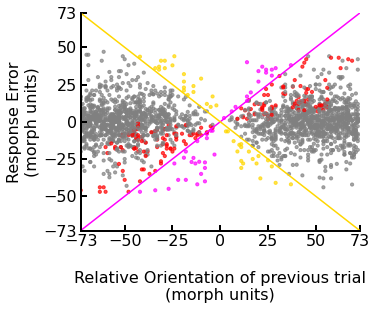

In [521]:
# plt.figure(figsize=(5, 4))
f, ax = plt.subplots(figsize=(5, 4))

ax.scatter(diff_category['Stim_diff'], diff_category['responseError'], c=diff_category['eff_extended'], alpha = 0.7, marker='o', s=10)
plt.xlim([-73, 73])
plt.ylim([-73, 73])

plt.yticks([-73, -50, -25, 0, 25, 50, 73])
plt.xticks([-73, -50, -25, 0, 25, 50, 73])
sns.despine()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='magenta')
ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='gold')
plt.ylabel('Response Error\n(morph units)')
plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
# plt.plot([0, 1], [0, 1])
# plt.show()#, transform=ax.transAxes)


In [381]:
def clockwise_definition(curr, prev):
    if (curr == 'A' and prev == 'B') or (curr == 'B' and prev == 'C') or (curr == 'C' and prev == 'A'):
        c = 'clockwise'
    elif (curr == 'B' and prev == 'A') or (curr == 'A' and prev == 'C') or (curr == 'C' and prev == 'B'):
        c = 'counterclockwise'
    return c

In [382]:
dw = diff_category.loc[diff_category['eff_extended'] == 'red', ['stimulusID', 'shifted_stimulusID', 'Stim_diff', 'responseError', 'distance', 'boundary', 'eff_extended']].reset_index(drop=True)
dw['responseError'] = dw['responseError'].round(4)
dw['category_current'] = dw['stimulusID'].apply(category_definition)
dw['category_previous'] = dw['shifted_stimulusID'].apply(category_definition)
for row in range(len(dw)):
    dw.loc[row, 'direction']= clockwise_definition(dw.loc[row, 'category_current'], dw.loc[row, 'category_previous'])
dw.rename(columns={'stimulusID': 'current', 'shifted_stimulusID': 'prev'}, inplace=True)

In [383]:
dw.head()

,current,prev,Stim_diff,responseError,distance,boundary,eff_extended,category_current,category_previous,direction
0,76.0,42.0,34.0,25.0000,1.0,75.0,red,C,B,counterclockwise
1,122.0,6.0,-30.0,-6.0000,-2.0,124.0,red,C,A,clockwise
2,75.0,49.0,26.0,7.9992,0.0,75.0,red,C,B,counterclockwise
3,83.0,43.0,40.0,9.0000,8.0,75.0,red,C,B,counterclockwise
4,82.0,40.0,42.0,31.0000,7.0,75.0,red,C,B,counterclockwise


In [522]:
total_dots = len(diff_category)
pink_dots = len(diff_category[(diff_category['eff_extended'] == 'magenta') | (diff_category['eff_extended'] == 'red')])
yellow_dots = len(diff_category[diff_category['eff_extended'] == 'gold'])
pink_dots_perc = pink_dots/total_dots

print('Number of total points:', total_dots)
print('Number of pink points:', pink_dots)
print('Number of yellow points:', yellow_dots)

Number of total points: 2139
Number of pink points: 202
Number of yellow points: 40


In [523]:
pink_dots_perc

0.09443665264142123

### Plusminus 25 

In [524]:
plusminus25 = diff_category[(diff_category['Stim_diff'] >= -25) & (diff_category['Stim_diff'] <= 25)].reset_index(drop=True)

In [525]:
for row in range(len(plusminus25)):
    distance, boundary = dist_boundary( plusminus25.loc[row, 'shifted_stimulusID'], plusminus25.loc[row, 'stimulusID'])
    
    plusminus25.loc[row, 'distance'] = distance
    plusminus25.loc[row, 'boundary'] = boundary

    
# plusminus25 = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
y = np.asarray(plusminus25['responseError'])
x = np.asarray(plusminus25['Stim_diff'])
z = np.asarray(plusminus25['distance'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            elif np.abs(y[idx]) > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')

            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            elif y[idx] > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')


            
plusminus25.loc[:, 'eff_extended'] = color
total_dots_plusminus25 = len(plusminus25)
pink_dots_plusminus25 = len(plusminus25[(plusminus25['eff_extended'] == 'magenta') | (plusminus25['eff_extended'] == 'red')])
yellow_dots_plusminus25 = len(plusminus25[plusminus25['eff_extended'] == 'gold'])
pink_dots_plusminus25_perc = pink_dots_plusminus25/total_dots_plusminus25

In [526]:
print('Number of total points:', total_dots_plusminus25)
print('Number of pink points:', pink_dots_plusminus25)
print('Number of yellow points:', yellow_dots_plusminus25)
print('Percentage of pink points:', pink_dots_plusminus25_perc)

Number of total points: 275
Number of pink points: 79
Number of yellow points: 30
Percentage of pink points: 0.2872727272727273


### Plusminus 15 

In [527]:
plusminus15 = diff_category[(diff_category['Stim_diff'] >= -15) & (diff_category['Stim_diff'] <= 15)].reset_index(drop=True)

In [528]:
for row in range(len(plusminus15)):
    distance, boundary = dist_boundary(plusminus15.loc[row, 'shifted_stimulusID'], plusminus15.loc[row, 'stimulusID'])
    
    plusminus15.loc[row, 'distance'] = distance
    plusminus15.loc[row, 'boundary'] = boundary

    
# plusminus15 = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
y = np.asarray(plusminus15['responseError'])
x = np.asarray(plusminus15['Stim_diff'])
z = np.asarray(plusminus15['distance'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            elif np.abs(y[idx]) > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')

            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            elif y[idx] > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')


            
plusminus15.loc[:, 'eff_extended'] = color
total_dots_plusminus15 = len(plusminus15)
pink_dots_plusminus15 = len(plusminus15[(plusminus15['eff_extended'] == 'magenta') | (plusminus15['eff_extended'] == 'red')])
yellow_dots_plusminus15 = len(plusminus15[plusminus15['eff_extended'] == 'gold'])
pink_dots_plusminus15_perc = pink_dots_plusminus15/total_dots_plusminus15

## Null 

In [531]:
def init_null_pink(data, is_plus_minus, how_much=25, nIterations=5000):
    data_null = pd.DataFrame(columns=['ITERATION', 'SUBJECT', 'TYPE', 'AMPLITUDE', 'SLOPE'])
    row = 0
    data['Stim_diff_og'] = data['Stim_diff']
    init_vals = [-25, 1.5]
    pink_dots = []
    pink_perc = []
    for iteration in range(nIterations):
        print(iteration)
        
        data['Stim_diff'] = data['Stim_diff_og'].sample(frac=1).reset_index(drop=True)

        data['same_category'] = data['stimulusID'].apply(category_definition) == data['shifted_stimulusID'].apply(category_definition)

        diff_category = data[data['same_category'] == False].reset_index(drop=True)
        
        for row in range(len(diff_category)):
            distance, boundary = dist_boundary(diff_category.loc[row, 'shifted_stimulusID'], diff_category.loc[row, 'stimulusID'])

            diff_category.loc[row, 'distance'] = distance
            diff_category.loc[row, 'boundary'] = boundary
        
        if is_plus_minus:
            diff_category = diff_category[(diff_category['Stim_diff'] >= -how_much) & (diff_category['Stim_diff'] <= how_much)]

        y = np.asarray(diff_category['responseError'])
        x = np.asarray(diff_category['Stim_diff'])
        z = np.asarray(diff_category['distance'])
        color=[]
        for idx in range(len(y)):
            if x[idx] < 0: # x[idx] is negative, left part of panel
                if y[idx] < 0: # y[idx] is negative, left bottom part of graph
                    if y[idx] < x[idx]:
                        color.append('magenta')
                    elif np.abs(y[idx]) > np.abs(z[idx]):
                        color.append('red')
                    else:
                        color.append('gray')
                else:
                    if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                        color.append('gold')

                    else:
                        color.append('gray')

            else: # x[idx] is positive, right part of panel
                if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
                    if y[idx] < -x[idx]:
                        color.append('gold')
                    else:
                        color.append('gray')
                else: # y[idx] is positive, right top part of the graph
                    if y[idx] > x[idx]:
                        color.append('magenta')
                    elif y[idx] > np.abs(z[idx]):
                        color.append('red')
                    else:
                        color.append('gray')



        diff_category.loc[:, 'eff_extended'] = color
        total_dots = len(diff_category)
        pink_dots_iteration = len(diff_category[(diff_category['eff_extended'] == 'magenta') | (diff_category['eff_extended'] == 'red')])
#         yellow_dots = len(diff_category[diff_category['eff_extended'] == 'gold'])
        pink_dots.append(pink_dots_iteration)
        pink_perc.append(pink_dots_iteration/total_dots)
    return pink_dots, pink_perc



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'All dots')

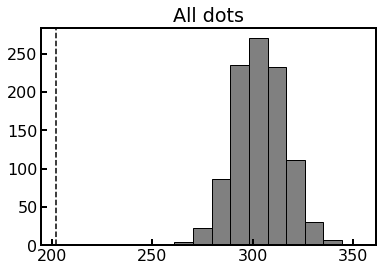

In [532]:
pink_dots_null, pink_dots_null_perc = init_null_pink(subjectdata, is_plus_minus=False, nIterations=1000)
plt.hist(pink_dots_null, color='gray', edgecolor='black')
plt.axvline(pink_dots, color='black', linestyle='--')
plt.title('All dots')

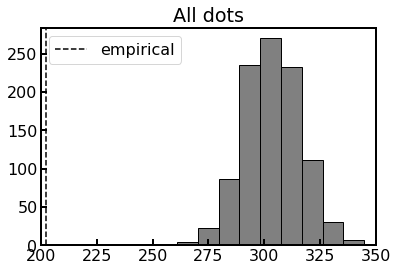

In [533]:
plt.hist(pink_dots_null, color='gray', edgecolor='black')
plt.axvline(pink_dots, color='black', linestyle='--', label='empirical')
plt.xlim([200, 350])
plt.legend()
plt.title('All dots');


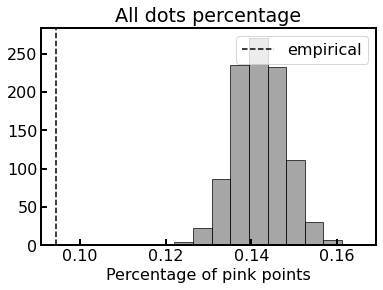

In [576]:
plt.hist(pink_dots_null_perc, color='gray', edgecolor='black', alpha=0.7)
plt.axvline(pink_dots_perc, color='black', linestyle='--', label='empirical')
# plt.xlim([0.1, 0.16])
plt.xlabel('Percentage of pink points')
plt.legend()
plt.title('All dots percentage');


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, '+-25')

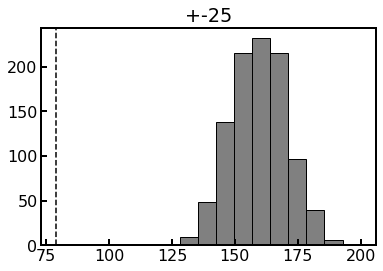

In [577]:
pink_dots_null_plusminus25, pink_dots_null_plusminus25_perc = init_null_pink(subjectdata, is_plus_minus=True, nIterations=1000)
plt.hist(pink_dots_null_plusminus25, color='gray', edgecolor='black')
plt.axvline(pink_dots_plusminus25, color='black', linestyle='--')
plt.title('+-25')

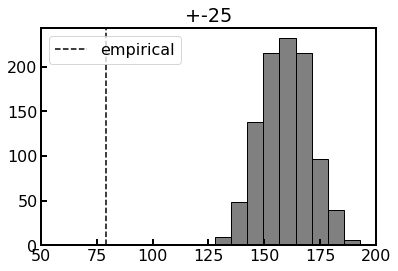

In [578]:
plt.hist(pink_dots_null_plusminus25, color='gray', edgecolor='black')
plt.axvline(pink_dots_plusminus25, color='black', linestyle='--', label='empirical')
plt.xlim([50, 200])
plt.legend()
plt.title('+-25');

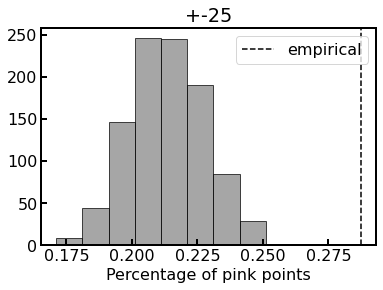

In [580]:
plt.hist(pink_dots_null_plusminus25_perc, color='gray', edgecolor='black', alpha=0.7)
plt.axvline(pink_dots_plusminus25_perc, color='black', linestyle='--', label='empirical')
# plt.xlim([0.16, 0.28])
plt.xlabel('Percentage of pink points')
plt.legend()
plt.title('+-25');

In [581]:
np.mean(pink_dots_null_plusminus25_perc)

0.21354993349166448

In [582]:
np.median(pink_dots_null_plusminus25_perc)

0.21341455577080215

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, '+-15')

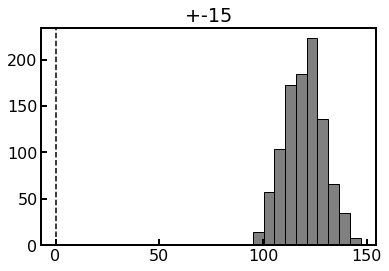

In [583]:
pink_dots_null_plusminus15, pink_dots_null_plusminus15_perc = init_null_pink(subjectdata, is_plus_minus=True, how_much=15,nIterations=1000)
plt.hist(pink_dots_null_plusminus15, color='gray', edgecolor='black')
plt.axvline(pink_dots_plusminus15_perc, color='black', linestyle='--')
plt.title('+-15')

Text(0.5, 1.0, '+-15')

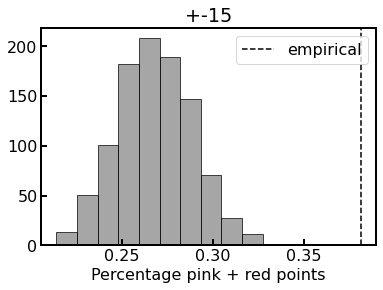

In [584]:
plt.hist(pink_dots_null_plusminus15_perc, color='gray', edgecolor='black', alpha=0.7)
plt.axvline(pink_dots_plusminus15_perc, color='black', linestyle='--', label='empirical')
plt.xlabel('Percentage pink + red points')
plt.legend()
plt.title('+-15')

## Nforward

In [304]:
futurepath = figures_path + '/data/radiologists/trials_forward/good_rbf/'

In [311]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']
future_supersubject = pd.DataFrame()
for subject in subject_names:
    tmp = pd.read_csv(futurepath + subject + '/' + subject + '_VM_output_1nBack.csv')
    tmp = tmp[(tmp['trialNumber'] >=1) & (tmp['trialNumber'] <=84)]
#     tmp['subject'] = subject
    future_supersubject = pd.concat([future_supersubject, tmp], axis=0)

In [316]:
len(future_supersubject)

3201

In [319]:
future_supersubject['same_category'] = future_supersubject['stimulusID'].apply(category_definition) == future_supersubject['shifted_stimulusID'].apply(category_definition)
diff_category_supersubject = future_supersubject[future_supersubject['same_category'] == False].reset_index(drop=True)


In [320]:
for row in range(len(diff_category_supersubject)):
    distance, boundary = dist_boundary(diff_category_supersubject.loc[row, 'stimulusID'], diff_category_supersubject.loc[row, 'shifted_stimulusID'])
    
    diff_category_supersubject.loc[row, 'distance'] = distance
    diff_category_supersubject.loc[row, 'boundary'] = boundary


In [321]:
# diff_category_supersubject = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
y = np.asarray(diff_category_supersubject['responseError'])
x = np.asarray(diff_category_supersubject['Stim_diff'])
z = np.asarray(diff_category_supersubject['distance'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            elif np.abs(y[idx]) > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')

            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            elif y[idx] > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')


            
diff_category_supersubject.loc[:, 'eff_extended'] = color
len(color) == len(y)  
            

True

Text(0.5, 1.0, 'N-forward trials')

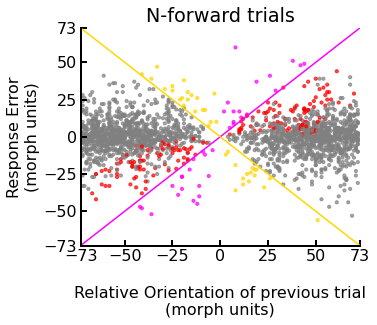

In [325]:
# plt.figure(figsize=(5, 4))
f, ax = plt.subplots(figsize=(5, 4))

ax.scatter(diff_category_supersubject['Stim_diff'], diff_category_supersubject['responseError'], c=diff_category_supersubject['eff_extended'], alpha = 0.7, marker='o', s=10)
plt.xlim([-73, 73])
plt.ylim([-73, 73])

plt.yticks([-73, -50, -25, 0, 25, 50, 73])
plt.xticks([-73, -50, -25, 0, 25, 50, 73])
sns.despine()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='magenta')
ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='gold')
plt.ylabel('Response Error\n(morph units)')
plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
plt.title('N-forward trials')
# plt.plot([0, 1], [0, 1])
# plt.show()#, transform=ax.transAxes)


In [323]:
total_dots = len(diff_category_supersubject)
pink_dots = len(diff_category_supersubject[(diff_category_supersubject['eff_extended'] == 'magenta') | (diff_category_supersubject['eff_extended'] == 'red')])
yellow_dots = len(diff_category_supersubject[diff_category_supersubject['eff_extended'] == 'gold'])
print('Number of total points:', total_dots)
print('Number of pink points:', pink_dots)
print('Number of yellow points:', yellow_dots)

Number of total points: 2147
Number of pink points: 208
Number of yellow points: 37


### Plusminus25 

In [408]:
plusminus25_future = diff_category_supersubject[(diff_category_supersubject['Stim_diff'] >= -25) & (diff_category_supersubject['Stim_diff'] <= 25)].reset_index(drop=True)
# diff_category_supersubject = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
y = np.asarray(plusminus25_future['responseError'])
x = np.asarray(plusminus25_future['Stim_diff'])
z = np.asarray(plusminus25_future['distance'])
color=[]
for idx in range(len(y)):
    if x[idx] < 0: # x[idx] is negative, left part of panel
        if y[idx] < 0: # y[idx] is negative, left bottom part of graph
            if y[idx] < x[idx]:
                color.append('magenta')
            elif np.abs(y[idx]) > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')
        else:
            if y[idx] > abs(x[idx]): # y[idx] is positive, left top part of the graph
                color.append('gold')

            else:
                color.append('gray')

    else: # x[idx] is positive, right part of panel
        if y[idx] < 0: # y[idx] is negatie, right bottom part of graph
            if y[idx] < -x[idx]:
                color.append('gold')
            else:
                color.append('gray')
        else: # y[idx] is positive, right top part of the graph
            if y[idx] > x[idx]:
                color.append('magenta')
            elif y[idx] > np.abs(z[idx]):
                color.append('red')
            else:
                color.append('gray')


            
plusminus25_future.loc[:, 'eff_extended'] = color
            


In [409]:
total_dots_future_25 = len(plusminus25_future)
pink_dots_future_25 = len(plusminus25_future[(plusminus25_future['eff_extended'] == 'magenta') | (plusminus25_future['eff_extended'] == 'red')])
yellow_dots_future_25 = len(plusminus25_future[plusminus25_future['eff_extended'] == 'gold'])
print('Number of total points:', total_dots_future_25)
print('Number of pink points:', pink_dots_future_25)
print('Number of yellow points:', yellow_dots_future_25)

Number of total points: 279
Number of pink points: 69
Number of yellow points: 31


# % of Anti-SD and Pro-SD

In [535]:
subject = 'SuperSubject'
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)


In [493]:
def fix_across_wheel(morph):
    if morph > 147:
        morph -= 147
    elif morph <= 0:
        morph = 147 - abs(morph)

    return morph
# subjectdata['response_morphID'] = subjectdata['stimulusID'] + subjectdata['Error']


In [494]:
# min(subjectdata['response_morphID']), max(subjectdata['response_morphID'])

(-35.0, 180.0)

In [495]:
# min(subjectdata['stimulusID']), max(subjectdata['stimulusID'])

(1.0, 147.0)

In [496]:
# subjectdata['response_morphID_fixed'] = subjectdata['response_morphID'].apply(fix_across_wheel)

In [497]:
# min(subjectdata['response_morphID_fixed']), max(subjectdata['response_morphID_fixed'])

(1.0, 147.0)

In [498]:
# min(subjectdata['stimulusID']), max(subjectdata['stimulusID'])

(1.0, 147.0)

In [516]:
subjectdata.head()

,stimulusID,morphID,RT,trialNumber,blockNumber,stimLocationDeg,shifted_stimulusID,shifted_stimLocationDeg,shifted_morphID,Error,...,Running_Mean,slopes,intercepts,DoVM,same_category,response_morphID,response_morphID_fixed,current_category,previous_category,response_category
0,67.0,72.0,2.899034,1.0,1.0,199.0,58.0,0.0,70.0,12.0,...,0.172058,0.193816,0.097387,-5.299618e-17,True,79.0,79.0,B,B,C
1,58.0,70.0,2.149815,2.0,1.0,0.0,57.0,331.0,76.0,19.0,...,0.127298,0.173817,-0.234304,-1.863737e-02,True,77.0,77.0,B,B,C
2,133.0,78.0,4.315844,4.0,1.0,235.0,135.0,277.0,143.0,8.0,...,-0.017763,0.182917,-0.651661,-3.735816e-02,True,141.0,141.0,A,A,A
3,135.0,143.0,3.183391,5.0,1.0,277.0,127.0,29.0,144.0,17.0,...,-0.109145,0.224286,0.402723,-5.624599e-02,True,152.0,5.0,A,A,A
4,127.0,144.0,1.099883,6.0,1.0,29.0,25.0,171.0,26.0,1.0,...,-0.252766,0.110848,-0.099127,-7.538492e-02,True,128.0,128.0,A,A,A


In [542]:
subjectdata['current_category'] = subjectdata['shifted_stimulusID'].apply(category_definition)
subjectdata['previous_category'] = subjectdata['stimulusID'].apply(category_definition)
subjectdata['response_category'] = subjectdata['shifted_morphID'].apply(category_definition)

In [543]:
mauro_data = subjectdata.copy()
mauro_data.loc[mauro_data['response_category'] == 'A', 'response_category'] = 1
mauro_data.loc[mauro_data['response_category'] == 'B', 'response_category'] = 2
mauro_data.loc[mauro_data['response_category'] == 'C', 'response_category'] = 3

In [544]:
mauro_data[['shifted_stimulusID', 'response_category']].to_csv('mauro_data.csv')

In [545]:
AB1 = subjectdata[(subjectdata['previous_category'] == 'A') &
                           (subjectdata['current_category'] == 'B')  &
                           (subjectdata['response_category'] == 'A')]
AC1 = subjectdata[(subjectdata['previous_category'] == 'A') &
                           (subjectdata['current_category'] == 'C')  &
                           (subjectdata['response_category'] == 'A')]       
BB1 = subjectdata[(subjectdata['previous_category'] == 'B') &
                           (subjectdata['current_category'] == 'B')  &
                           (subjectdata['response_category'] == 'A')]
BC1 = subjectdata[(subjectdata['previous_category'] == 'B') &
                           (subjectdata['current_category'] == 'C')  &
                           (subjectdata['response_category'] == 'A')]  
CB1 = subjectdata[(subjectdata['previous_category'] == 'C') &
                           (subjectdata['current_category'] == 'B')  &
                           (subjectdata['response_category'] == 'A')]  
CC1 = subjectdata[(subjectdata['previous_category'] == 'C') &
                           (subjectdata['current_category'] == 'C')  &
                           (subjectdata['response_category'] == 'A')]  


In [546]:
BA2 = subjectdata[(subjectdata['previous_category'] == 'B') &
                           (subjectdata['current_category'] == 'A')  &
                           (subjectdata['response_category'] == 'B')]
BC2 = subjectdata[(subjectdata['previous_category'] == 'B') &
                           (subjectdata['current_category'] == 'C')  &
                           (subjectdata['response_category'] == 'B')]       
AA2 = subjectdata[(subjectdata['previous_category'] == 'A') &
                           (subjectdata['current_category'] == 'A')  &
                           (subjectdata['response_category'] == 'B')]
AC2 = subjectdata[(subjectdata['previous_category'] == 'A') &
                           (subjectdata['current_category'] == 'C')  &
                           (subjectdata['response_category'] == 'B')]  
CA2 = subjectdata[(subjectdata['previous_category'] == 'C') &
                           (subjectdata['current_category'] == 'A')  &
                           (subjectdata['response_category'] == 'B')]  
CC2 = subjectdata[(subjectdata['previous_category'] == 'C') &
                           (subjectdata['current_category'] == 'C')  &
                           (subjectdata['response_category'] == 'B')] 

In [547]:
CA3 = subjectdata[(subjectdata['previous_category'] == 'C') &
                           (subjectdata['current_category'] == 'A')  &
                           (subjectdata['response_category'] == 'C')]

CB3 = subjectdata[(subjectdata['previous_category'] == 'C') &
                           (subjectdata['current_category'] == 'B')  &
                           (subjectdata['response_category'] == 'C')]

AA3 = subjectdata[(subjectdata['previous_category'] == 'A') &
                           (subjectdata['current_category'] == 'A')  &
                           (subjectdata['response_category'] == 'C')]

AB3 = subjectdata[(subjectdata['previous_category'] == 'A') &
                           (subjectdata['current_category'] == 'B')  &
                           (subjectdata['response_category'] == 'C')]

BA3 = subjectdata[(subjectdata['previous_category'] == 'B') &
                           (subjectdata['current_category'] == 'A')  &
                           (subjectdata['response_category'] == 'C')]

BB3 = subjectdata[(subjectdata['previous_category'] == 'B') &
                           (subjectdata['current_category'] == 'B')  &
                           (subjectdata['response_category'] == 'C')]

In [548]:
SD1 = (len(AB1) + len(AC1))/(len(AB1) + len(AC1) + len(BB1) + len(BC1) + len(CB1) + len(CC1))

In [549]:
SD2 = (len(BA2) + len(BC2))/(len(BA2) + len(BC2) + len(AA2) + len(AC2) + len(CA2) + len(CC2))

In [550]:
SD3 = (len(CA3) + len(CB3))/(len(CA3) + len(CB3) + len(AA3) + len(AB3) + len(BA3) + len(BB3))

In [568]:
SD_total = (SD1 + SD2 + SD3)/3
SD_total

0.41431830381105744

In [569]:
SD_total -= 0.3333
SD_total

0.08101830381105746

In [570]:
SD3

0.39351851851851855

In [571]:
antiSD1 = (len(BC1) + len(CB1))/(len(AB1) + len(AC1) + len(BB1) + len(BC1) + len(CB1) + len(CC1))

In [572]:
antiSD2 = (len(AC2) + len(CA2))/(len(BA2) + len(BC2) + len(AA2) + len(AC2) + len(CA2) + len(CC2))

In [573]:
antiSD3 = (len(AB3) + len(BA3))/(len(CA3) + len(CB3) + len(AA3) + len(AB3) + len(BA3) + len(BB3))

In [574]:
antiSD_total = (antiSD1 + antiSD2 + antiSD3)/3
antiSD_total

0.31394256575415996

In [575]:
antiSD_total -= 0.3333
antiSD_total * 100

-1.9357434245840022

# efficiency

In [590]:
def amplitude_calc(data, title):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError'], p0=init_vals, bounds = ([-60,2],[60,4]))
    #### RUNNING MEAN ####
    RM, xvals = getRunningMean(data['Stim_diff'], data['responseError'], step = 20)

    plt.figure(figsize=(5, 4))
    plt.plot(data['Stim_diff'], data['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in data['Stim_diff']]
    plt.plot(x, y, '-', linewidth = 4, color='k')
    plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
    peak_x = (x[np.argmax(y)])
    poly1d_fn, coef = getRegressionLine(x = data['Stim_diff'], y= data['responseError'], peak = peak_x)
    xdata = np.linspace(-peak_x, peak_x, 100)
    plt.plot(xdata, poly1d_fn(xdata), linestyle='--', color='powderblue', linewidth = 4)
    plt.xlim([-73, 73])
    plt.ylim([-60, 60])
    plt.yticks(np.arange(-60, 70, 10))
    # plt.xticks(np.arange(-70, 80, 20))
    plt.xticks([-73, -50, -25, 0, 25, 50, 73])
    sns.despine()
    # print(coef[0], coef[1])
    plt.title('Current and previous\n ' + title)
    plt.ylabel('Response Error\n(morph units)')
    plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
    plt.legend()
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.eps', bbox_inches='tight', dpi=1200)
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.jpg', bbox_inches='tight', dpi=1200)
    plt.show()
    
    if x[np.argmax(y)] > 0: 
        amplitude = np.max(y)
    else: 
        amplitude = -np.max(y)
    return x, y

        
def vm(x, mean, kai, amplitude):
    x = (x/53)*np.pi
    return amplitude * (np.exp(kai * np.cos(x-mean)) / (i0(kai) * 2 * np.pi))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


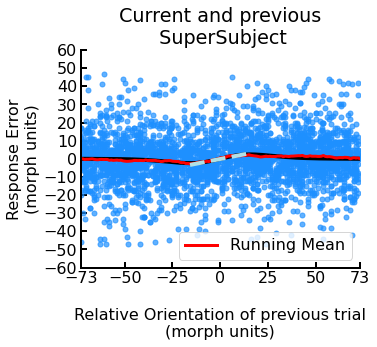

In [637]:
subject = 'SuperSubject'
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)].reset_index(drop=True)
x_dog, y_dog = amplitude_calc(subjectdata, subject)

In [653]:
np.max(y_dog)

2.410365260614903

In [654]:
out = []
for idx in range(len(x_dog)):
    out.append(y_dog[idx]/x_dog[idx])
    


In [655]:
x_axis_tmp = np.linspace(-75, 75, 300)
crd = 3.97
x_axis = []
for idx in range(len(x_axis_tmp)):
    x_axis.append(x_axis_tmp[idx]/crd)


In [640]:
len(x_axis)

300

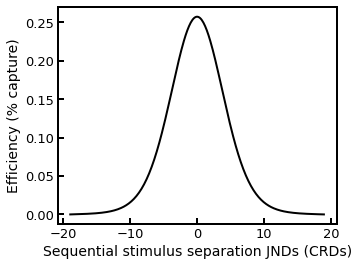

In [656]:
plt.figure(figsize=(5, 4))
plt.plot(x_axis, out, linewidth=2, color='black')
plt.ylabel('Efficiency (% capture)', fontsize=14)
plt.xlabel('Sequential stimulus separation JNDs (CRDs)', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);


In [643]:
out[150]

0.2573603845950775

In [429]:
np.save('efficiency_radiologists_x', x_axis)
np.save('efficiency_radiologists_y', out)


## Bootstrap 

In [752]:
def DoG(x, amplitude, sigma2):
    return - amplitude * x / (sigma2 ** 1.5 * np.sqrt(2 * np.pi)) * exp(- x ** 2 / (2 * sigma2))

def efficiency_xy(x_dog, y_dog):
    efficiency_y = []

    for idx in range(len(x_dog)): 
        efficiency_y.append(y_dog[idx]/x_dog[idx])



#     efficiency_x_tmp = np.linspace(-75, 75, 300)
    crd = 3.97
    efficiency_x = []
    for idx in range(len(x_dog)):
        efficiency_x.append(x_dog[idx]/crd)
        
    return efficiency_x, efficiency_y
        
def CurvefitFunc(x, y, func=DoG, init_vals=[-20, 10], bounds_input = ([-np.inf,10],[0,74])):
    best_vals, covar = curve_fit(func, x, y, p0=init_vals, bounds = bounds_input)
    return best_vals

def getRunningMean(stimuli_diff, filtered_responseError, halfway =74, step = 8):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

In [ ]:
best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError'], p0=init_vals, bounds = ([-60,2],[60,4]))
x = np.linspace(-75, 75, 300)
y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]


In [795]:
efficiency_x_iterations = pd.DataFrame()
efficiency_y_iterations = pd.DataFrame()

# bounds_input = ([-60,2],[60,4])
subject = 'SuperSubject'
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)].reset_index(drop=True)


init_vals=[-20, 10]
init_vals2 = [-25, 4]
init_vals3=[-25, 1.5]
bounds_input = ([-np.inf,10],[0,74])
bounds_input2 = ([-60,2],[60,4])
bounds_input3 = ([-60,1],[60,1.5])
OutA = [] # Output a array, store each trial's a
x = subjectdata['Stim_diff']
y = subjectdata['responseError']
bsSize = int(1.0 * len(x))

for i in range(1000):
    RandIndex = np.random.choice(len(x), bsSize, replace=True) # get randi index of xdata
    xdataNEW = [x[i] for i in RandIndex] # change xdata index
    ydataNEW = [y[i] for i in RandIndex] # change ydata index
    try:
        best_vals, covar = curve_fit(vonmise_derivative, xdataNEW, ydataNEW, p0=init_vals3, bounds = bounds_input3)
#         best_vals, covar = curve_fit(vonmise_derivative, xdataNEW, ydataNEW, p0=init_vals, bounds = bounds_input)
#         temp_best_vals = CurvefitFunc(xdataNEW, ydataNEW, init_vals=init_vals, bounds_input=bounds_input)
        new_x = np.linspace(-75, 75, 300)
        new_y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in new_x]

#         new_y = [DoG(xi,temp_best_vals[0],temp_best_vals[1]) for xi in xdataNEW]
        efficiency_x, efficiency_y = efficiency_xy(new_x, new_y)
        
        efficiency_x_iterations[str(i)] = efficiency_x
        efficiency_y_iterations[str(i)] = efficiency_y
        OutA.append(np.max(new_y))

    except RuntimeError:
        pass
print("bs_a:",round(np.mean(OutA),2),"	95% CI:",np.percentile(OutA,[2.5,97.5]))



bs_a: 2.21 	95% CI: [1.4977354  2.99944967]


In [764]:
# new_x
min(xdataNEW), max(xdataNEW)

(-73.0, 72.0)

In [796]:
# for i in range(len(efficiency_y_iterations)):
#     efficiency_y_iterations.loc[i, 'UPPER'] = sorted(efficiency_y_iterations.iloc[i, :])[int(0.975*1000)]
#     efficiency_y_iterations.loc[i, 'LOWER'] = sorted(efficiency_y_iterations.iloc[i, :])[int(0.025*1000)]
#     efficiency_y_iterations.loc[i, 'MEAN'] = np.mean(efficiency_y_iterations.iloc[i, :])
    
    

In [801]:
efficiency_y_iterations_copy = efficiency_y_iterations.copy()
for i in range(len(efficiency_y_iterations)):
    efficiency_y_iterations.loc[i, 'UPPER'] = sorted(efficiency_y_iterations_copy.iloc[i, :])[int(0.975*1000)]
    efficiency_y_iterations.loc[i, 'LOWER'] = sorted(efficiency_y_iterations_copy.iloc[i, :])[int(0.025*1000)]
    efficiency_y_iterations.loc[i, 'MEDIAN'] = np.median(efficiency_y_iterations_copy.iloc[i, :])
    efficiency_y_iterations.loc[i, 'MEAN'] = np.mean(efficiency_y_iterations_copy.iloc[i, :])
    
    

In [804]:
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


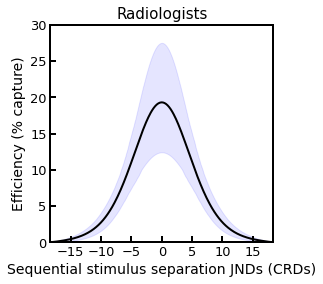

In [805]:
plt.figure(figsize=(4, 4))
plt.plot(efficiency_x_iterations.iloc[:, 0], efficiency_y_iterations['MEAN']*100 , linewidth=2, color='black')
plt.fill_between(efficiency_x_iterations.iloc[:, 0], efficiency_y_iterations['LOWER']*100, efficiency_y_iterations['UPPER']*100, color='b', alpha=.1)
crd_radiologists = 3.97
minx = -73/crd_radiologists
maxx= 73/crd_radiologists
plt.xlim([minx, maxx])
plt.xticks([-15, -10, -5, 0, 5, 10, 15])
plt.ylim([0, 30])
plt.yticks(np.arange(0, 32, 5))
plt.ylabel('Efficiency (% capture)', fontsize=14)
plt.xlabel('Sequential stimulus separation JNDs (CRDs)', fontsize=14)
plt.title('Radiologists', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);
plt.savefig('Efficiency_radiologists.eps',bbox_inches='tight', dpi=1000)
plt.savefig('Efficiency_radiologists.svg',bbox_inches='tight', dpi=1000)
plt.savefig('Efficiency_radiologists.jpg',bbox_inches='tight', dpi=1000)
plt.savefig('Efficiency_radiologists.pdf',bbox_inches='tight', dpi=1000)